In [1]:
from google.colab import drive
drive.mount('/content/drive')

project_dir = "/content/drive/My Drive/Colab Notebooks/COSE474 Deep Learning HW/20242R0136COSE47402/Final Project"
image_dir = pkl_dir = project_dir + "/data/scatterplots"
model_dir = project_dir + "/models"
# finetuned model url : https://drive.google.com/drive/folders/19Z1eESBlPtuy8-PYoRca9nezZdjQdAct?usp=sharing

Mounted at /content/drive


In [2]:
!pip install transformers datasets
!pip install accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.4 MB/s eta 0:00:00


In [3]:
import torch
from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from torch.nn import CrossEntropyLoss
from PIL import Image

import os

# Check for CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load pre-trained model and processor
processor = Pix2StructProcessor.from_pretrained("google/deplot")
base_model = Pix2StructForConditionalGeneration.from_pretrained("google/deplot").to(device)

finetuned_model = Pix2StructForConditionalGeneration.from_pretrained(model_dir).to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [4]:
import pickle
with open(pkl_dir + '/dataset_test.pkl', 'rb') as f:
    test_dataset = pickle.load(f)
test_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 2500
})

## Compute the Test Loss (Cross Entropy Loss)

In [33]:
from tqdm import tqdm

loss_baseline = []
loss_finetuned = []

for i in tqdm(range(2500)):
  inputs = processor(images=test_dataset[i]["image"], text="Generate underlying data table of the figure below:", return_tensors="pt")
  inputs["labels"] = processor.tokenizer(test_dataset[i]["text"], return_tensors="pt", max_length=398, padding="max_length", truncation=True)["input_ids"]
  inputs.to(device)

  # 모델 출력(finetuned)
  with torch.no_grad():
      outputs = finetuned_model(**inputs)
  # loss 계산
  loss = outputs.loss
  loss_finetuned.append(loss.item())

  #모델 출력(baseline)
  with torch.no_grad():
      outputs = base_model(**inputs)

  # 손실 계산
  loss = outputs.loss
  loss_baseline.append(loss.item())

print("")
print(loss_baseline)
print(loss_finetuned)


100%|██████████| 2500/2500 [41:57<00:00,  1.01s/it]


[20.297760009765625, 25.647367477416992, 21.389511108398438, 12.417078018188477, 15.00115966796875, 15.677135467529297, 14.52161693572998, 19.763715744018555, 16.868688583374023, 22.329591751098633, 21.641036987304688, 27.435640335083008, 16.698877334594727, 24.690216064453125, 22.796812057495117, 13.95731258392334, 21.695104598999023, 19.11495018005371, 21.53307342529297, 23.811471939086914, 16.114274978637695, 14.196720123291016, 25.9185848236084, 12.355143547058105, 23.775564193725586, 16.712095260620117, 20.889741897583008, 25.268611907958984, 11.087615013122559, 20.533288955688477, 13.632803916931152, 17.39221954345703, 8.843134880065918, 8.254582405090332, 17.4481143951416, 21.527729034423828, 11.929229736328125, 11.168108940124512, 17.60603141784668, 18.13658905029297, 15.715713500976562, 14.681306838989258, 25.31363868713379, 20.878185272216797, 20.860498428344727, 16.4447078704834, 10.793511390686035, 16.734512329101562, 18.827301025390625, 21.919597625732422, 14.651894569396

### Test Loss Save

In [36]:
loss_baseline = [20.297760009765625, 25.647367477416992, 21.389511108398438, 12.417078018188477, 15.00115966796875, 15.677135467529297, 14.52161693572998, 19.763715744018555, 16.868688583374023, 22.329591751098633, 21.641036987304688, 27.435640335083008, 16.698877334594727, 24.690216064453125, 22.796812057495117, 13.95731258392334, 21.695104598999023, 19.11495018005371, 21.53307342529297, 23.811471939086914, 16.114274978637695, 14.196720123291016, 25.9185848236084, 12.355143547058105, 23.775564193725586, 16.712095260620117, 20.889741897583008, 25.268611907958984, 11.087615013122559, 20.533288955688477, 13.632803916931152, 17.39221954345703, 8.843134880065918, 8.254582405090332, 17.4481143951416, 21.527729034423828, 11.929229736328125, 11.168108940124512, 17.60603141784668, 18.13658905029297, 15.715713500976562, 14.681306838989258, 25.31363868713379, 20.878185272216797, 20.860498428344727, 16.4447078704834, 10.793511390686035, 16.734512329101562, 18.827301025390625, 21.919597625732422, 14.651894569396973, 17.868619918823242, 16.566329956054688, 24.027080535888672, 20.087867736816406, 14.622323989868164, 19.77175521850586, 16.457294464111328, 24.80093765258789, 15.092451095581055, 15.67631721496582, 8.850924491882324, 22.09090805053711, 15.258315086364746, 16.127580642700195, 20.33814811706543, 8.333314895629883, 9.27079963684082, 19.547313690185547, 19.154714584350586, 15.745919227600098, 19.386463165283203, 18.31151580810547, 16.03630828857422, 15.325939178466797, 16.65032386779785, 12.96928596496582, 20.49233627319336, 24.12069320678711, 19.390819549560547, 10.565790176391602, 17.094411849975586, 18.86687660217285, 9.822871208190918, 25.769683837890625, 16.62493324279785, 19.50446128845215, 23.76104736328125, 13.720758438110352, 19.531198501586914, 22.99864387512207, 19.851289749145508, 17.738422393798828, 16.622753143310547, 22.617137908935547, 18.38235092163086, 23.688987731933594, 20.908937454223633, 17.863008499145508, 24.342273712158203, 16.910757064819336, 13.671012878417969, 18.9223690032959, 19.2340030670166, 15.470059394836426, 12.28265380859375, 20.2878475189209, 10.070287704467773, 13.948100090026855, 20.72567367553711, 28.12375259399414, 25.114830017089844, 15.191856384277344, 17.814983367919922, 23.822546005249023, 24.727458953857422, 28.666444778442383, 9.736412048339844, 21.871829986572266, 14.902158737182617, 19.78025245666504, 14.642706871032715, 16.336227416992188, 20.03571128845215, 22.875362396240234, 10.105744361877441, 14.008369445800781, 14.203271865844727, 22.15066146850586, 14.177656173706055, 17.109981536865234, 23.663362503051758, 11.094538688659668, 21.37515640258789, 20.863794326782227, 15.959553718566895, 21.555442810058594, 22.397655487060547, 11.088348388671875, 22.992082595825195, 18.39312744140625, 11.547591209411621, 25.071428298950195, 24.511959075927734, 15.583270072937012, 18.885202407836914, 20.250429153442383, 16.63404083251953, 12.641748428344727, 3.9870777130126953, 8.546792984008789, 22.54165267944336, 17.084638595581055, 27.716764450073242, 19.296009063720703, 19.387638092041016, 23.074079513549805, 18.4058780670166, 20.658048629760742, 18.05811309814453, 13.780265808105469, 10.507282257080078, 20.6389102935791, 13.72318172454834, 16.21036148071289, 26.730466842651367, 17.261808395385742, 20.38347625732422, 14.851306915283203, 11.18619441986084, 21.216018676757812, 12.96202278137207, 26.322343826293945, 14.520490646362305, 15.836623191833496, 14.536044120788574, 20.220256805419922, 18.416086196899414, 20.043235778808594, 15.522285461425781, 22.56546401977539, 21.81487274169922, 13.538344383239746, 19.801292419433594, 15.988648414611816, 25.287282943725586, 25.095874786376953, 21.15846824645996, 14.643545150756836, 20.022489547729492, 21.55130386352539, 23.2757568359375, 21.430355072021484, 10.54449462890625, 21.081268310546875, 7.626308917999268, 22.674686431884766, 11.390581130981445, 16.334028244018555, 18.6639461517334, 20.261873245239258, 23.11823844909668, 15.949919700622559, 18.403709411621094, 11.53923225402832, 17.821395874023438, 8.18889331817627, 10.372514724731445, 17.7915096282959, 28.618112564086914, 18.686779022216797, 14.133917808532715, 19.810565948486328, 11.686173439025879, 15.864107131958008, 17.741924285888672, 16.43368911743164, 19.736238479614258, 21.447086334228516, 22.27302360534668, 13.210933685302734, 12.338489532470703, 20.606678009033203, 18.12116813659668, 21.427392959594727, 14.57858657836914, 18.37421989440918, 19.221784591674805, 26.5291748046875, 19.907888412475586, 23.925195693969727, 12.921283721923828, 16.402048110961914, 25.174781799316406, 13.670174598693848, 16.827119827270508, 11.60845947265625, 17.034521102905273, 20.896759033203125, 21.083599090576172, 18.73622703552246, 12.58761978149414, 15.271056175231934, 13.898453712463379, 26.758121490478516, 15.94394302368164, 22.937034606933594, 28.20686912536621, 13.505684852600098, 26.260183334350586, 18.29704475402832, 11.314615249633789, 24.645042419433594, 18.637880325317383, 21.79488754272461, 14.346055030822754, 18.981229782104492, 19.199077606201172, 10.306798934936523, 11.936396598815918, 17.068496704101562, 13.71788501739502, 6.390875816345215, 21.304405212402344, 11.397520065307617, 4.999216556549072, 17.368125915527344, 18.523807525634766, 22.688152313232422, 11.412062644958496, 17.36039161682129, 17.56041717529297, 22.427309036254883, 22.646818161010742, 20.373044967651367, 15.089035034179688, 15.538822174072266, 21.93886947631836, 13.599334716796875, 20.635717391967773, 22.256973266601562, 22.494285583496094, 14.35216999053955, 23.728986740112305, 12.158910751342773, 19.840429306030273, 25.30328941345215, 16.785959243774414, 24.560230255126953, 18.698972702026367, 15.228857040405273, 17.01278305053711, 22.438430786132812, 14.464996337890625, 17.37318229675293, 7.144637584686279, 9.89398193359375, 22.387569427490234, 14.355632781982422, 13.329718589782715, 23.867172241210938, 20.323286056518555, 16.219497680664062, 15.324355125427246, 23.547319412231445, 22.927268981933594, 17.56399917602539, 21.897050857543945, 21.287126541137695, 19.97782325744629, 23.261396408081055, 16.077716827392578, 18.81757354736328, 28.747756958007812, 17.849824905395508, 21.770687103271484, 16.183805465698242, 18.220867156982422, 26.94881820678711, 15.406850814819336, 15.985278129577637, 19.140914916992188, 12.51527214050293, 15.834146499633789, 19.13528060913086, 16.346128463745117, 17.937055587768555, 20.798786163330078, 13.545878410339355, 21.89095115661621, 25.30276870727539, 25.546133041381836, 15.850077629089355, 20.18890380859375, 6.555434226989746, 25.932071685791016, 12.516084671020508, 15.402338027954102, 27.31279945373535, 19.70547866821289, 16.869556427001953, 17.84564208984375, 13.216217994689941, 23.11301612854004, 14.029549598693848, 7.447225093841553, 18.931913375854492, 21.78601837158203, 20.955421447753906, 21.32369041442871, 7.100399494171143, 14.424590110778809, 19.891523361206055, 17.758392333984375, 13.142107963562012, 13.117841720581055, 26.394332885742188, 19.313732147216797, 20.77323341369629, 23.19075584411621, 24.095531463623047, 16.277042388916016, 18.490711212158203, 18.11534309387207, 12.809999465942383, 11.087456703186035, 17.94187355041504, 8.576661109924316, 16.403581619262695, 21.66438102722168, 14.902400016784668, 14.585391998291016, 16.92729949951172, 15.161356925964355, 22.738128662109375, 11.821417808532715, 14.76177978515625, 13.267784118652344, 13.378701210021973, 18.713260650634766, 20.59190559387207, 20.11948013305664, 11.38087272644043, 16.614015579223633, 28.85930633544922, 20.30254364013672, 15.239828109741211, 17.65365219116211, 12.965231895446777, 18.538311004638672, 15.487663269042969, 18.10784339904785, 18.123584747314453, 11.511316299438477, 16.766008377075195, 11.505172729492188, 7.224099636077881, 23.445234298706055, 23.651723861694336, 18.078720092773438, 26.450151443481445, 16.338655471801758, 22.892099380493164, 15.09586238861084, 17.692602157592773, 21.98392677307129, 15.653962135314941, 13.802412033081055, 16.884220123291016, 17.271440505981445, 20.616561889648438, 19.864927291870117, 11.663771629333496, 20.537853240966797, 17.752296447753906, 24.558523178100586, 19.186832427978516, 15.39690113067627, 24.21246337890625, 12.643996238708496, 26.08034896850586, 15.435670852661133, 12.983796119689941, 22.06926918029785, 18.55848503112793, 13.607139587402344, 23.654802322387695, 23.04810905456543, 24.829904556274414, 17.051143646240234, 18.933887481689453, 23.1829776763916, 23.406972885131836, 21.89740753173828, 17.109268188476562, 17.306161880493164, 25.708009719848633, 23.84945297241211, 15.796720504760742, 11.813919067382812, 16.1971378326416, 13.681730270385742, 14.35404109954834, 18.998594284057617, 16.39038848876953, 20.044174194335938, 14.80527114868164, 23.1735782623291, 15.946622848510742, 14.398138046264648, 14.573187828063965, 16.774999618530273, 23.185016632080078, 14.104206085205078, 13.47118854522705, 16.67711639404297, 12.825202941894531, 11.399016380310059, 13.924880981445312, 15.619361877441406, 18.88552474975586, 17.550979614257812, 20.66899871826172, 21.72445297241211, 19.194849014282227, 12.572739601135254, 21.840578079223633, 17.668916702270508, 21.881820678710938, 10.906181335449219, 29.507238388061523, 23.823408126831055, 18.07362174987793, 20.065433502197266, 18.094648361206055, 20.348331451416016, 19.757558822631836, 6.897827625274658, 14.723052978515625, 10.139177322387695, 23.419055938720703, 11.322269439697266, 19.422433853149414, 26.767040252685547, 14.952247619628906, 16.457809448242188, 15.450297355651855, 19.781566619873047, 18.716537475585938, 19.198657989501953, 17.619565963745117, 12.842645645141602, 17.339866638183594, 20.09084701538086, 24.987422943115234, 14.23698902130127, 15.443343162536621, 17.373544692993164, 17.224143981933594, 17.740144729614258, 20.42438316345215, 13.395241737365723, 20.032833099365234, 17.993419647216797, 10.066473960876465, 21.711196899414062, 9.42766284942627, 18.79285430908203, 23.891136169433594, 20.042736053466797, 21.561941146850586, 17.685300827026367, 14.447278022766113, 19.138755798339844, 27.572847366333008, 19.957447052001953, 13.15625, 25.49866485595703, 10.91562271118164, 14.47131633758545, 22.815298080444336, 24.050479888916016, 14.434094429016113, 16.05165672302246, 17.519285202026367, 18.122587203979492, 13.94984245300293, 18.411056518554688, 16.91965103149414, 19.50527572631836, 6.718955039978027, 19.33213233947754, 16.250280380249023, 11.340841293334961, 16.864521026611328, 22.126585006713867, 22.2592830657959, 16.74648666381836, 15.070446014404297, 25.50558853149414, 12.514592170715332, 18.95207977294922, 17.123430252075195, 22.67120933532715, 15.292474746704102, 16.47823143005371, 16.047863006591797, 22.020706176757812, 7.334056377410889, 7.924436569213867, 21.55371856689453, 18.878347396850586, 26.645517349243164, 15.047030448913574, 17.594449996948242, 21.08562660217285, 14.66287612915039, 23.75162124633789, 20.826263427734375, 5.310673236846924, 15.432937622070312, 21.49590492248535, 22.828218460083008, 21.179603576660156, 14.783503532409668, 15.30184268951416, 17.418373107910156, 13.663997650146484, 28.603055953979492, 25.928573608398438, 21.413015365600586, 23.91175079345703, 15.677872657775879, 21.32878303527832, 17.809993743896484, 20.33980941772461, 14.776272773742676, 22.074453353881836, 16.359390258789062, 18.117395401000977, 17.388381958007812, 22.714834213256836, 14.485156059265137, 18.978580474853516, 14.477011680603027, 21.797391891479492, 11.019183158874512, 24.035533905029297, 12.304449081420898, 27.93885612487793, 18.594989776611328, 18.173133850097656, 28.863561630249023, 27.224775314331055, 18.053312301635742, 21.110179901123047, 16.41629981994629, 15.959650993347168, 18.2143497467041, 17.10426902770996, 18.639026641845703, 26.2167911529541, 23.121871948242188, 25.517152786254883, 16.398283004760742, 18.66046714782715, 18.6994571685791, 18.80316734313965, 21.5627498626709, 24.785842895507812, 21.187131881713867, 18.82670783996582, 22.81975555419922, 17.37026023864746, 21.476905822753906, 15.342340469360352, 22.969192504882812, 17.337858200073242, 18.27596664428711, 18.238908767700195, 19.61557388305664, 19.303878784179688, 19.632617950439453, 25.476444244384766, 20.548049926757812, 16.645233154296875, 11.84335708618164, 20.491580963134766, 11.169698715209961, 21.670135498046875, 20.230833053588867, 16.040250778198242, 13.225359916687012, 12.635966300964355, 16.20619010925293, 6.700257301330566, 12.422835350036621, 22.504880905151367, 17.487491607666016, 16.61264991760254, 11.058414459228516, 23.84950065612793, 16.9226131439209, 14.948182106018066, 16.5769100189209, 19.146678924560547, 21.176225662231445, 26.288789749145508, 17.972890853881836, 21.681461334228516, 18.964828491210938, 16.315736770629883, 26.833087921142578, 19.242162704467773, 21.575740814208984, 17.265506744384766, 12.552450180053711, 18.20780372619629, 12.781773567199707, 15.01606559753418, 11.22854232788086, 20.846206665039062, 12.774822235107422, 19.153120040893555, 13.380376815795898, 25.009857177734375, 11.188143730163574, 23.005661010742188, 14.641083717346191, 27.186994552612305, 17.61012840270996, 21.982738494873047, 8.868385314941406, 14.368630409240723, 15.436419486999512, 19.783954620361328, 21.8015079498291, 18.305150985717773, 21.695423126220703, 18.56102180480957, 20.264368057250977, 24.850683212280273, 13.487922668457031, 18.403934478759766, 22.393630981445312, 20.926183700561523, 16.81189727783203, 17.53489875793457, 18.880483627319336, 17.519065856933594, 15.280341148376465, 19.47411346435547, 1.4680989980697632, 18.4802188873291, 19.42039680480957, 16.134592056274414, 13.315143585205078, 11.554876327514648, 19.420419692993164, 11.466854095458984, 16.5958251953125, 21.826017379760742, 4.1347126960754395, 11.90295124053955, 15.786090850830078, 15.234208106994629, 22.966657638549805, 28.485660552978516, 23.666879653930664, 27.755943298339844, 14.323383331298828, 18.542591094970703, 7.411312103271484, 21.542583465576172, 9.30447006225586, 6.224182605743408, 15.547852516174316, 19.36459732055664, 13.019209861755371, 15.760424613952637, 17.474342346191406, 13.393567085266113, 19.44176483154297, 22.806163787841797, 14.668466567993164, 17.710660934448242, 17.611169815063477, 14.288077354431152, 20.704347610473633, 19.81422233581543, 10.174159049987793, 19.9490966796875, 12.811330795288086, 17.855287551879883, 22.375974655151367, 13.108734130859375, 22.550405502319336, 14.527382850646973, 15.688498497009277, 17.42639923095703, 11.830497741699219, 17.921289443969727, 7.624156475067139, 26.937475204467773, 14.734318733215332, 20.64122772216797, 24.01535415649414, 24.129804611206055, 18.309062957763672, 21.188154220581055, 10.321542739868164, 21.001148223876953, 20.327425003051758, 22.138418197631836, 21.099523544311523, 8.351898193359375, 16.169050216674805, 14.900430679321289, 18.75905418395996, 24.777597427368164, 13.72205638885498, 23.670576095581055, 13.094534873962402, 14.138426780700684, 20.49420738220215, 10.024744987487793, 10.364574432373047, 21.492984771728516, 19.284725189208984, 18.674068450927734, 14.46914005279541, 20.05583953857422, 24.727617263793945, 16.569963455200195, 18.389333724975586, 24.367387771606445, 10.696255683898926, 19.61145782470703, 26.505558013916016, 11.743343353271484, 14.96377182006836, 16.770875930786133, 22.331655502319336, 17.777421951293945, 19.81424331665039, 20.605545043945312, 20.720157623291016, 21.815635681152344, 16.873987197875977, 21.96074104309082, 21.89900016784668, 20.01380157470703, 18.65610694885254, 18.706714630126953, 28.428918838500977, 25.351699829101562, 19.710845947265625, 28.145036697387695, 10.80946159362793, 19.149553298950195, 16.18007469177246, 26.469924926757812, 22.2634220123291, 19.7845458984375, 25.004499435424805, 27.21725082397461, 14.59886360168457, 17.060989379882812, 6.945004463195801, 14.204808235168457, 16.517988204956055, 26.282493591308594, 24.432897567749023, 14.771993637084961, 15.176465034484863, 17.43740463256836, 20.283037185668945, 17.363174438476562, 13.412284851074219, 15.17977237701416, 16.244421005249023, 12.100826263427734, 17.56997299194336, 23.42871856689453, 20.106088638305664, 9.589577674865723, 23.392377853393555, 12.791089057922363, 22.52998924255371, 17.939334869384766, 15.605463027954102, 15.501704216003418, 20.76437759399414, 12.150209426879883, 24.660938262939453, 19.77592658996582, 17.87460708618164, 20.13064193725586, 22.702556610107422, 16.271459579467773, 21.290464401245117, 31.639144897460938, 18.54126739501953, 18.158042907714844, 17.527082443237305, 14.827444076538086, 20.354022979736328, 16.247058868408203, 16.2758846282959, 18.164878845214844, 14.889165878295898, 21.424991607666016, 21.82990837097168, 20.920495986938477, 16.713031768798828, 18.404380798339844, 17.290922164916992, 22.358869552612305, 27.11408042907715, 18.316146850585938, 20.842113494873047, 20.572099685668945, 10.588350296020508, 23.031028747558594, 19.754262924194336, 14.568492889404297, 23.27320671081543, 24.1094970703125, 18.962936401367188, 21.040315628051758, 15.72066879272461, 24.39776039123535, 20.85637664794922, 18.802265167236328, 18.70616912841797, 10.516609191894531, 9.694276809692383, 11.398411750793457, 13.2896146774292, 19.888439178466797, 15.965418815612793, 21.256032943725586, 20.331544876098633, 20.476390838623047, 13.499079704284668, 19.659061431884766, 14.302962303161621, 26.086820602416992, 17.02726936340332, 23.389623641967773, 17.275117874145508, 13.708788871765137, 22.746076583862305, 8.452459335327148, 21.706485748291016, 22.489803314208984, 13.717920303344727, 17.9367733001709, 18.81123161315918, 23.42540168762207, 12.186755180358887, 15.98163890838623, 13.271906852722168, 17.631460189819336, 17.63581085205078, 12.79435920715332, 16.042274475097656, 22.053956985473633, 13.335959434509277, 18.721969604492188, 7.424034118652344, 19.894956588745117, 25.82413101196289, 17.51516342163086, 23.934528350830078, 18.23836898803711, 18.34324073791504, 17.50674819946289, 8.534778594970703, 20.18293571472168, 19.373781204223633, 15.761731147766113, 20.34044075012207, 20.325305938720703, 7.978415012359619, 26.28875732421875, 11.743965148925781, 18.302188873291016, 11.758317947387695, 26.35810661315918, 19.256473541259766, 18.903213500976562, 11.789602279663086, 10.269636154174805, 17.30748176574707, 23.67557716369629, 17.701934814453125, 16.631813049316406, 8.873948097229004, 18.197174072265625, 17.287330627441406, 18.790225982666016, 25.05254554748535, 22.161766052246094, 22.008075714111328, 23.316492080688477, 13.280557632446289, 13.892848014831543, 14.213704109191895, 16.041379928588867, 20.84267234802246, 16.332138061523438, 14.000823974609375, 24.616226196289062, 11.680907249450684, 18.091283798217773, 18.624591827392578, 16.523813247680664, 13.358882904052734, 17.54922103881836, 14.833683013916016, 24.577411651611328, 18.619779586791992, 18.28780174255371, 15.715157508850098, 25.103179931640625, 14.663554191589355, 18.364944458007812, 21.3109130859375, 13.31499195098877, 13.368608474731445, 21.21454429626465, 17.013103485107422, 26.27372932434082, 21.20537757873535, 22.41604232788086, 14.283138275146484, 23.33169937133789, 14.03509521484375, 17.186504364013672, 12.077116966247559, 11.14387035369873, 23.352678298950195, 21.268526077270508, 13.717041015625, 16.55590057373047, 1.6061471700668335, 17.17819595336914, 19.67372703552246, 18.1036319732666, 24.842439651489258, 18.947277069091797, 19.472869873046875, 23.829187393188477, 14.284773826599121, 17.971338272094727, 12.102317810058594, 10.32323932647705, 21.58853530883789, 16.233369827270508, 15.328564643859863, 19.504148483276367, 23.117605209350586, 9.794875144958496, 18.553110122680664, 13.43937873840332, 22.690412521362305, 24.015789031982422, 16.472681045532227, 19.290983200073242, 15.401988983154297, 20.497676849365234, 20.96269989013672, 22.95294761657715, 15.769488334655762, 24.269060134887695, 21.2728214263916, 24.153995513916016, 22.683921813964844, 17.207813262939453, 16.149770736694336, 19.26446533203125, 9.850878715515137, 26.5919189453125, 11.871783256530762, 28.160762786865234, 24.23499870300293, 17.537981033325195, 13.291315078735352, 22.94012451171875, 21.384305953979492, 23.40287208557129, 14.643657684326172, 16.99043846130371, 6.449490070343018, 21.294710159301758, 23.566516876220703, 18.11357879638672, 14.38143253326416, 20.49500274658203, 27.0546932220459, 24.041980743408203, 13.730039596557617, 20.369020462036133, 16.687990188598633, 18.70773696899414, 18.33425521850586, 20.018817901611328, 18.351320266723633, 22.357290267944336, 19.064523696899414, 25.248701095581055, 26.95914649963379, 11.438881874084473, 17.675756454467773, 21.675518035888672, 15.633359909057617, 24.143478393554688, 13.51120376586914, 14.860980033874512, 15.94666576385498, 20.671127319335938, 13.672508239746094, 17.446352005004883, 20.683446884155273, 16.43745994567871, 14.097538948059082, 22.57867431640625, 12.280587196350098, 19.814971923828125, 19.06814193725586, 13.74472427368164, 13.316934585571289, 20.202150344848633, 16.331153869628906, 16.132417678833008, 17.517637252807617, 19.784523010253906, 9.890278816223145, 25.213838577270508, 18.7739315032959, 22.8284912109375, 16.48845863342285, 12.306862831115723, 16.924772262573242, 19.617918014526367, 16.52124786376953, 17.716859817504883, 20.132896423339844, 21.91094970703125, 19.67380142211914, 17.252416610717773, 19.524730682373047, 16.71917152404785, 14.74106502532959, 16.213550567626953, 11.71985149383545, 22.9487247467041, 16.10458755493164, 16.719078063964844, 16.51161766052246, 12.072402954101562, 32.546749114990234, 16.798526763916016, 25.83069610595703, 21.855337142944336, 8.879570960998535, 14.066801071166992, 16.518308639526367, 15.270054817199707, 15.349682807922363, 15.674825668334961, 25.929969787597656, 11.532784461975098, 17.905597686767578, 27.29920196533203, 17.480472564697266, 26.14818000793457, 17.23695182800293, 8.760258674621582, 13.069272994995117, 15.498655319213867, 19.672903060913086, 16.904701232910156, 17.50409698486328, 22.041484832763672, 20.68636131286621, 16.744739532470703, 22.89488410949707, 21.965343475341797, 15.96689510345459, 19.431028366088867, 21.408321380615234, 15.158355712890625, 22.77444839477539, 17.76209259033203, 15.262743949890137, 9.08326530456543, 19.91646385192871, 17.02713394165039, 17.021404266357422, 29.179601669311523, 22.51797866821289, 21.16002655029297, 22.225841522216797, 15.852470397949219, 17.688344955444336, 23.97625732421875, 20.2025089263916, 20.243860244750977, 26.835481643676758, 16.970531463623047, 22.70280647277832, 19.609638214111328, 21.11516571044922, 17.554073333740234, 22.661846160888672, 21.57976722717285, 19.465755462646484, 16.66704559326172, 19.05497169494629, 15.040237426757812, 19.410297393798828, 18.752683639526367, 15.96292781829834, 16.565792083740234, 18.68914222717285, 8.666335105895996, 20.887441635131836, 6.91268253326416, 22.849435806274414, 19.23183822631836, 21.141876220703125, 13.624815940856934, 20.945220947265625, 16.02617835998535, 23.0104923248291, 18.949535369873047, 25.22274398803711, 19.046052932739258, 17.054149627685547, 10.148736953735352, 23.28818130493164, 9.735311508178711, 17.877979278564453, 17.539505004882812, 24.634851455688477, 16.151836395263672, 18.44552993774414, 18.29117202758789, 16.97019386291504, 24.70612144470215, 2.4648776054382324, 14.83217716217041, 14.776982307434082, 14.364339828491211, 17.727413177490234, 16.991769790649414, 17.638906478881836, 14.84100341796875, 19.91313362121582, 13.505046844482422, 17.574541091918945, 13.11412239074707, 18.93182373046875, 17.824748992919922, 19.16425132751465, 12.385696411132812, 14.516831398010254, 20.584993362426758, 15.935054779052734, 16.888301849365234, 13.597036361694336, 22.29962158203125, 23.84090805053711, 18.98591423034668, 16.438770294189453, 13.741863250732422, 22.433231353759766, 19.434791564941406, 25.932537078857422, 18.89898681640625, 12.924403190612793, 15.608112335205078, 23.910512924194336, 18.951007843017578, 17.396556854248047, 22.154563903808594, 23.612091064453125, 16.832857131958008, 19.886491775512695, 14.986692428588867, 19.911849975585938, 10.454177856445312, 20.833892822265625, 22.35322380065918, 20.595869064331055, 28.6922607421875, 19.496299743652344, 17.748987197875977, 11.398744583129883, 11.127388954162598, 16.406517028808594, 20.08912467956543, 17.516664505004883, 21.99225616455078, 21.597023010253906, 18.663118362426758, 29.753780364990234, 5.671286582946777, 17.91889190673828, 19.083553314208984, 16.49056625366211, 17.218700408935547, 17.656749725341797, 17.1114501953125, 13.630029678344727, 14.675898551940918, 21.920284271240234, 21.382869720458984, 11.2421236038208, 18.504409790039062, 18.208423614501953, 16.82115936279297, 21.957656860351562, 20.989229202270508, 16.878450393676758, 19.609859466552734, 23.45132827758789, 14.574969291687012, 19.471454620361328, 17.454736709594727, 16.83857536315918, 15.986719131469727, 18.733747482299805, 20.783159255981445, 20.235107421875, 22.45113182067871, 14.64572525024414, 16.4251708984375, 12.246821403503418, 20.181154251098633, 26.002056121826172, 22.23675537109375, 22.162012100219727, 9.006597518920898, 21.918201446533203, 14.947822570800781, 23.615074157714844, 13.431242942810059, 14.394660949707031, 21.084367752075195, 20.4731502532959, 26.307640075683594, 17.356393814086914, 16.66720962524414, 24.242856979370117, 21.08233070373535, 24.22111701965332, 21.254549026489258, 19.78519630432129, 14.405278205871582, 13.160335540771484, 23.58072280883789, 21.738327026367188, 19.93181800842285, 13.777039527893066, 17.595645904541016, 22.441970825195312, 21.35174560546875, 15.040671348571777, 21.259164810180664, 12.004448890686035, 14.313488960266113, 18.29775619506836, 18.91170883178711, 16.977481842041016, 32.741336822509766, 17.1572322845459, 23.29722023010254, 19.441007614135742, 21.439905166625977, 18.68956756591797, 10.632405281066895, 22.10358428955078, 10.865665435791016, 22.476396560668945, 21.445146560668945, 22.5123291015625, 17.452882766723633, 12.432478904724121, 19.696760177612305, 22.006427764892578, 12.747635841369629, 18.325918197631836, 15.189745903015137, 18.26172637939453, 27.1656494140625, 12.164200782775879, 20.00499725341797, 22.377269744873047, 13.452534675598145, 11.224933624267578, 20.055923461914062, 19.498567581176758, 23.669404983520508, 20.655879974365234, 13.745100021362305, 24.36312484741211, 15.826652526855469, 23.129804611206055, 20.314781188964844, 15.683258056640625, 25.04192352294922, 13.168280601501465, 20.306779861450195, 17.103822708129883, 7.656676769256592, 15.889974594116211, 21.824569702148438, 15.296659469604492, 18.6225528717041, 14.97436237335205, 19.682161331176758, 19.27151107788086, 21.107637405395508, 10.709053993225098, 21.939905166625977, 17.003822326660156, 15.286476135253906, 19.09368324279785, 10.053667068481445, 19.26870346069336, 20.30340576171875, 17.246511459350586, 21.910310745239258, 21.698774337768555, 9.45196533203125, 19.97308921813965, 17.293498992919922, 15.748028755187988, 20.05263328552246, 12.843545913696289, 17.89315414428711, 18.737533569335938, 17.235774993896484, 17.784069061279297, 20.139406204223633, 18.79279899597168, 24.371673583984375, 16.678422927856445, 22.338056564331055, 21.748493194580078, 16.73214340209961, 19.595422744750977, 12.20329475402832, 15.30350112915039, 6.468944072723389, 15.020931243896484, 17.52955436706543, 19.915342330932617, 28.060152053833008, 27.568708419799805, 15.51594352722168, 24.6612606048584, 22.40317726135254, 15.261046409606934, 20.11072540283203, 16.365144729614258, 30.17497444152832, 23.651487350463867, 16.27889633178711, 19.089794158935547, 16.470645904541016, 23.427410125732422, 20.999740600585938, 11.701836585998535, 13.954597473144531, 18.6268367767334, 18.568584442138672, 26.04184341430664, 22.472259521484375, 15.220176696777344, 16.340457916259766, 16.15762710571289, 19.39723777770996, 12.493112564086914, 10.318882942199707, 19.67350196838379, 12.873835563659668, 19.82012367248535, 26.81224250793457, 18.670074462890625, 21.24996566772461, 20.672964096069336, 11.394076347351074, 14.552289009094238, 26.744962692260742, 10.83679485321045, 19.092796325683594, 14.886011123657227, 18.60710334777832, 21.85440444946289, 15.529274940490723, 23.101547241210938, 14.889904022216797, 21.258663177490234, 17.123369216918945, 10.862293243408203, 8.886714935302734, 15.671387672424316, 25.722259521484375, 15.837748527526855, 23.781370162963867, 17.279842376708984, 12.961261749267578, 21.114788055419922, 15.303378105163574, 8.414709091186523, 18.915311813354492, 23.827964782714844, 21.28217315673828, 11.778338432312012, 14.620037078857422, 19.34358024597168, 18.897598266601562, 16.652992248535156, 8.809196472167969, 17.468603134155273, 12.726238250732422, 23.033349990844727, 17.42453384399414, 27.383161544799805, 18.536964416503906, 21.616085052490234, 21.536697387695312, 22.15339469909668, 12.575119018554688, 6.967355251312256, 22.603147506713867, 21.37848472595215, 14.672283172607422, 22.82624053955078, 20.17612075805664, 17.097623825073242, 15.565759658813477, 14.65471076965332, 12.850993156433105, 14.728434562683105, 15.380256652832031, 22.197452545166016, 15.652417182922363, 20.332183837890625, 16.949607849121094, 18.57699966430664, 24.2408447265625, 20.42056655883789, 7.5639262199401855, 20.003135681152344, 18.13104820251465, 15.428380966186523, 19.279638290405273, 22.724464416503906, 27.700523376464844, 14.825024604797363, 20.761436462402344, 18.57556915283203, 12.300331115722656, 20.06065559387207, 15.547073364257812, 14.990633964538574, 17.8350887298584, 18.70172882080078, 21.978214263916016, 18.781505584716797, 21.309410095214844, 14.267093658447266, 20.564180374145508, 15.241398811340332, 21.030681610107422, 17.653120040893555, 24.702241897583008, 16.704265594482422, 15.434381484985352, 20.087644577026367, 11.55656623840332, 23.533004760742188, 17.779661178588867, 16.812013626098633, 15.096135139465332, 22.03538703918457, 20.393444061279297, 17.139789581298828, 17.8410701751709, 22.332046508789062, 12.340827941894531, 19.12736701965332, 18.87908363342285, 10.74707317352295, 11.47085189819336, 17.035842895507812, 19.933317184448242, 21.139690399169922, 10.482815742492676, 15.548833847045898, 17.397424697875977, 14.872601509094238, 25.910621643066406, 17.81542205810547, 24.86677360534668, 17.297746658325195, 18.797704696655273, 19.86625862121582, 10.973483085632324, 14.398187637329102, 11.707640647888184, 15.581841468811035, 22.663286209106445, 23.443862915039062, 25.654979705810547, 23.22295570373535, 21.32962417602539, 6.77805757522583, 16.777286529541016, 15.721302032470703, 16.693708419799805, 18.079057693481445, 17.469135284423828, 14.123580932617188, 19.38758087158203, 19.339780807495117, 11.314525604248047, 11.558080673217773, 15.052271842956543, 23.268959045410156, 12.082991600036621, 23.8995418548584, 11.900155067443848, 5.0692830085754395, 7.060178756713867, 18.306880950927734, 13.45161247253418, 13.864601135253906, 9.59946060180664, 11.15289306640625, 16.868112564086914, 11.181653022766113, 18.65226173400879, 18.317461013793945, 20.35870933532715, 11.904827117919922, 27.317359924316406, 19.085657119750977, 16.630348205566406, 16.229717254638672, 20.2880859375, 20.01579475402832, 17.626686096191406, 13.961814880371094, 19.535547256469727, 20.918201446533203, 20.736927032470703, 10.687195777893066, 14.54787826538086, 21.12141227722168, 21.390005111694336, 24.459001541137695, 23.976058959960938, 11.480770111083984, 12.50401496887207, 18.12860679626465, 23.131345748901367, 28.302291870117188, 20.4818115234375, 12.376992225646973, 21.847299575805664, 16.123504638671875, 19.562314987182617, 6.906702041625977, 18.4639892578125, 21.627681732177734, 16.426639556884766, 13.976780891418457, 21.580766677856445, 15.309638977050781, 16.218698501586914, 14.82705307006836, 21.285627365112305, 28.519365310668945, 16.63270378112793, 15.851763725280762, 22.62122344970703, 17.868038177490234, 11.019149780273438, 20.846237182617188, 17.645248413085938, 22.635025024414062, 19.9770565032959, 17.49964714050293, 17.7716007232666, 18.006568908691406, 24.164371490478516, 24.841384887695312, 19.033950805664062, 9.70345687866211, 20.824520111083984, 8.874120712280273, 20.13759994506836, 21.953027725219727, 7.563035488128662, 20.332151412963867, 13.088850975036621, 16.53097152709961, 16.02971649169922, 21.533836364746094, 20.653305053710938, 19.84551429748535, 21.495025634765625, 17.35491943359375, 18.608102798461914, 25.179996490478516, 20.02204704284668, 24.427230834960938, 29.979251861572266, 20.868276596069336, 22.414642333984375, 3.0495047569274902, 19.657901763916016, 19.680641174316406, 17.807735443115234, 20.490764617919922, 21.4788818359375, 22.00859260559082, 17.203420639038086, 13.609834671020508, 19.883031845092773, 15.669197082519531, 21.7045841217041, 19.949277877807617, 21.211889266967773, 12.393763542175293, 13.528619766235352, 20.651695251464844, 19.774770736694336, 23.190418243408203, 17.45008659362793, 13.570043563842773, 19.119998931884766, 17.10886573791504, 12.720667839050293, 25.872154235839844, 19.971216201782227, 13.649946212768555, 23.913349151611328, 21.024303436279297, 22.517072677612305, 19.04793930053711, 15.02849292755127, 23.432199478149414, 15.290106773376465, 23.56682777404785, 16.674068450927734, 16.825057983398438, 22.30268096923828, 15.31497859954834, 22.804994583129883, 20.38631820678711, 25.25201416015625, 20.74459457397461, 26.158649444580078, 17.83911895751953, 18.0892333984375, 20.58112335205078, 19.86017417907715, 24.055952072143555, 19.98076629638672, 20.835660934448242, 20.58078384399414, 20.099367141723633, 21.0075740814209, 21.090286254882812, 22.37520408630371, 20.58562660217285, 26.058183670043945, 14.727261543273926, 26.164661407470703, 29.926288604736328, 20.264368057250977, 20.42169761657715, 23.493610382080078, 17.47352409362793, 16.678682327270508, 13.894962310791016, 19.660367965698242, 19.95503807067871, 19.971940994262695, 22.996030807495117, 23.500947952270508, 20.716794967651367, 10.558826446533203, 25.817800521850586, 17.353837966918945, 15.812971115112305, 22.73320770263672, 19.372379302978516, 23.018003463745117, 11.26883602142334, 20.554336547851562, 21.955659866333008, 17.11579704284668, 19.813480377197266, 23.945613861083984, 16.578310012817383, 19.797815322875977, 19.654531478881836, 24.04803466796875, 20.344200134277344, 20.98093032836914, 24.372385025024414, 23.185091018676758, 19.541587829589844, 24.592687606811523, 1.614368200302124, 21.18655776977539, 27.208513259887695, 19.37411117553711, 19.213815689086914, 25.91526985168457, 21.986711502075195, 17.380769729614258, 19.59853172302246, 18.435510635375977, 19.903846740722656, 20.73843002319336, 20.581680297851562, 18.79497528076172, 20.0726375579834, 18.188796997070312, 21.89551544189453, 16.03398895263672, 22.436676025390625, 21.037939071655273, 10.28682804107666, 23.309633255004883, 18.7468204498291, 13.339755058288574, 22.819072723388672, 17.815980911254883, 14.713202476501465, 23.026094436645508, 19.65487289428711, 22.672937393188477, 23.038049697875977, 20.214189529418945, 13.717323303222656, 13.044939994812012, 9.256648063659668, 18.68247413635254, 21.552637100219727, 18.448455810546875, 24.68708038330078, 15.588172912597656, 18.90401268005371, 12.761380195617676, 16.138864517211914, 21.632732391357422, 25.574100494384766, 13.286951065063477, 23.793798446655273, 21.09636116027832, 20.166608810424805, 15.898691177368164, 16.704023361206055, 18.963441848754883, 18.755659103393555, 27.142532348632812, 13.622454643249512, 12.898776054382324, 21.722972869873047, 20.648305892944336, 18.68030548095703, 19.998437881469727, 17.119070053100586, 12.289057731628418, 18.146211624145508, 23.571334838867188, 21.293636322021484, 12.494770050048828, 18.012544631958008, 15.772982597351074, 20.89800262451172, 21.315441131591797, 8.683883666992188, 20.18563461303711, 12.643198013305664, 16.676918029785156, 18.363758087158203, 18.44540023803711, 23.008087158203125, 14.890870094299316, 14.844978332519531, 16.725006103515625, 9.316801071166992, 20.106395721435547, 21.42629623413086, 23.417688369750977, 20.88014030456543, 23.04619026184082, 15.47713565826416, 18.022981643676758, 21.775039672851562, 20.970129013061523, 13.545581817626953, 17.166467666625977, 25.812374114990234, 21.971927642822266, 6.3382391929626465, 25.613265991210938, 21.43204116821289, 18.4722900390625, 18.60942268371582, 14.414773941040039, 11.31726360321045, 19.194299697875977, 18.96650505065918, 16.38484001159668, 18.407678604125977, 16.752931594848633, 14.632246971130371, 16.164525985717773, 12.543538093566895, 19.094167709350586, 22.61399269104004, 23.410526275634766, 17.786855697631836, 14.75622272491455, 26.40095329284668, 24.22544288635254, 25.34389877319336, 14.228437423706055, 18.813404083251953, 18.744909286499023, 13.811304092407227, 13.687201499938965, 23.18219757080078, 16.167354583740234, 8.488149642944336, 23.62602996826172, 18.270706176757812, 20.095966339111328, 13.246285438537598, 13.360475540161133, 17.545223236083984, 18.471845626831055, 12.470419883728027, 17.574417114257812, 17.344438552856445, 13.27670669555664, 20.792139053344727, 17.072370529174805, 15.007192611694336, 15.032036781311035, 20.00257110595703, 18.536884307861328, 20.86387825012207, 18.182464599609375, 9.938006401062012, 12.345437049865723, 14.942641258239746, 19.79120445251465, 25.26740837097168, 9.588827133178711, 12.5122709274292, 20.69924545288086, 19.320690155029297, 10.373960494995117, 22.761821746826172, 20.07938003540039, 17.05721092224121, 16.081829071044922, 20.183774948120117, 13.307770729064941, 21.974063873291016, 17.548986434936523, 21.490734100341797, 14.530927658081055, 29.85634422302246, 19.202930450439453, 21.088111877441406, 24.396554946899414, 13.758544921875, 13.95738697052002, 20.02728271484375, 16.979066848754883, 17.945589065551758, 22.613367080688477, 20.391067504882812, 27.664899826049805, 20.90062141418457, 21.00353240966797, 10.400556564331055, 19.62570571899414, 21.495731353759766, 15.600507736206055, 23.422122955322266, 20.69260597229004, 27.50826644897461, 14.543342590332031, 16.926435470581055, 12.373791694641113, 26.44450569152832, 18.36023712158203, 15.327489852905273, 16.967267990112305, 15.052377700805664, 16.67791748046875, 17.522043228149414, 23.74823570251465, 24.750709533691406, 16.15221405029297, 26.269495010375977, 22.398555755615234, 16.643253326416016, 18.565156936645508, 17.690311431884766, 19.150129318237305, 12.553136825561523, 19.1490535736084, 16.29214096069336, 17.009687423706055, 13.875080108642578, 16.07428741455078, 22.655841827392578, 18.46014976501465, 10.006329536437988, 15.318984985351562, 21.757144927978516, 13.427096366882324, 18.71759605407715, 13.489716529846191, 12.587129592895508, 21.94397735595703, 25.21106719970703, 10.75753116607666, 12.666926383972168, 18.81627655029297, 19.30863380432129, 19.557382583618164, 15.04945182800293, 17.69146728515625, 24.444427490234375, 20.359861373901367, 24.03026580810547, 17.630836486816406, 8.661105155944824, 20.013986587524414, 23.24252700805664, 26.41568374633789, 17.812767028808594, 18.073711395263672, 10.914562225341797, 22.673662185668945, 14.241230964660645, 13.343587875366211, 17.17973518371582, 17.148115158081055, 17.40717887878418, 14.147449493408203, 20.40472984313965, 7.979848384857178, 18.75327491760254, 20.69029998779297, 22.40182876586914, 21.899120330810547, 9.443370819091797, 21.753597259521484, 15.202706336975098, 10.709112167358398, 21.946683883666992, 18.977142333984375, 13.491815567016602, 17.05350685119629, 14.219466209411621, 11.739420890808105, 15.579889297485352, 15.42520809173584, 11.643440246582031, 11.991232872009277, 15.69033145904541, 19.918258666992188, 18.928470611572266, 16.775135040283203, 15.555985450744629, 20.395893096923828, 18.28129005432129, 16.769365310668945, 22.603796005249023, 16.715721130371094, 25.816789627075195, 20.19735336303711, 20.57135009765625, 16.913726806640625, 21.49603271484375, 16.45713233947754, 20.60472297668457, 21.112747192382812, 20.02951431274414, 18.210519790649414, 24.651424407958984, 21.63457679748535, 14.990779876708984, 27.885696411132812, 23.279409408569336, 25.349607467651367, 17.46450424194336, 13.272756576538086, 25.91712760925293, 11.079353332519531, 14.988350868225098, 24.56869888305664, 10.67955207824707, 13.357975959777832, 8.96424388885498, 13.555591583251953, 23.547714233398438, 16.31830406188965, 14.174163818359375, 13.510055541992188, 25.912914276123047, 10.423968315124512, 8.472281455993652, 21.169872283935547, 20.032812118530273, 18.736013412475586, 20.8361759185791, 22.936735153198242, 23.903867721557617, 16.282550811767578, 13.26711654663086, 21.10734748840332, 21.795677185058594, 21.157527923583984, 13.514625549316406, 20.026823043823242, 28.548873901367188, 22.77107048034668, 17.087934494018555, 24.310501098632812, 13.738995552062988, 13.171417236328125, 16.839143753051758, 13.732279777526855, 5.602436542510986, 16.247831344604492, 18.689746856689453, 15.761439323425293, 18.43124771118164, 18.73181915283203, 19.880727767944336, 17.35413360595703, 22.851518630981445, 13.557100296020508, 16.69509506225586, 8.592428207397461, 5.955122470855713, 19.62151336669922, 23.232234954833984, 12.508224487304688, 25.456600189208984, 20.0720157623291, 18.748680114746094, 21.935522079467773, 21.240327835083008, 15.815990447998047, 21.088899612426758, 20.76258087158203, 29.563093185424805, 25.78365707397461, 15.347249984741211, 19.3789119720459, 20.148632049560547, 25.108789443969727, 14.175864219665527, 23.85494041442871, 23.226348876953125, 19.677120208740234, 16.637432098388672, 19.63219451904297, 15.31752872467041, 14.875057220458984, 19.6340274810791, 9.277592658996582, 7.853627681732178, 11.318790435791016, 23.436473846435547, 12.057961463928223, 22.919273376464844, 5.843102931976318, 22.82113265991211, 26.785480499267578, 17.75012969970703, 22.403799057006836, 15.699796676635742, 9.819075584411621, 22.975666046142578, 9.192782402038574, 18.268611907958984, 11.379765510559082, 22.533693313598633, 17.264781951904297, 13.679421424865723, 22.801034927368164, 13.708760261535645, 8.314962387084961, 11.364258766174316, 21.1905574798584, 16.670364379882812, 19.356964111328125, 19.746551513671875, 15.394582748413086, 22.40308952331543, 18.1070613861084, 17.839763641357422, 15.119474411010742, 20.794139862060547, 20.535484313964844, 21.840078353881836, 18.06476593017578, 23.4652042388916, 11.388591766357422, 25.985422134399414, 18.616947174072266, 28.409442901611328, 13.119531631469727, 19.502899169921875, 10.257363319396973, 19.828933715820312, 14.604840278625488, 22.652063369750977, 11.39454460144043, 9.765695571899414, 20.594749450683594, 12.107177734375, 10.356800079345703, 18.15123748779297, 17.062490463256836, 18.68638801574707, 18.786226272583008, 24.662561416625977, 22.064733505249023, 24.214683532714844, 19.159456253051758, 19.910707473754883, 18.60085678100586, 23.910959243774414, 18.466520309448242, 16.36306381225586, 19.784696578979492, 14.462102890014648, 6.471246719360352, 17.662765502929688, 10.51965045928955, 12.946399688720703, 17.928739547729492, 21.021854400634766, 17.488872528076172, 19.7357177734375, 8.638298034667969, 12.236183166503906, 19.78169059753418, 14.38870620727539, 25.466650009155273, 21.294811248779297, 12.158869743347168, 15.939637184143066, 13.042074203491211, 15.523141860961914, 22.120262145996094, 16.527589797973633, 24.397520065307617, 16.380340576171875, 21.376941680908203, 22.551477432250977, 14.398612022399902, 17.3582763671875, 20.68234634399414, 21.21449851989746, 14.756972312927246, 20.932174682617188, 9.775675773620605, 19.19789695739746, 16.855844497680664, 13.534595489501953, 20.40277862548828, 18.585844039916992, 22.078319549560547, 21.624176025390625, 19.976160049438477, 21.59796714782715, 14.635581016540527, 10.166675567626953, 16.669740676879883, 17.33740234375, 17.315208435058594, 15.626099586486816, 14.249622344970703, 15.101797103881836, 22.842313766479492, 18.786746978759766, 23.114940643310547, 26.605642318725586, 19.404281616210938, 20.28209114074707, 24.86212158203125, 19.50237464904785, 27.0122127532959, 14.746988296508789, 12.870939254760742, 18.32579803466797, 10.003457069396973, 17.470109939575195, 20.655977249145508, 9.553179740905762, 21.353200912475586, 17.5371036529541, 17.891244888305664, 24.320331573486328, 9.433149337768555, 19.16498374938965, 19.968734741210938, 8.062751770019531, 19.51902198791504, 17.838342666625977, 16.080387115478516, 20.172771453857422, 13.434402465820312, 21.931528091430664, 18.812389373779297, 23.029285430908203, 15.558024406433105, 8.32034969329834, 19.596832275390625, 17.067569732666016, 17.03551483154297, 8.73069953918457, 16.924741744995117, 20.96055030822754, 18.89164161682129, 26.097192764282227, 21.22643280029297, 15.69731616973877, 18.976911544799805, 17.533479690551758, 11.034992218017578, 20.56224822998047, 13.415581703186035, 22.108125686645508, 16.279205322265625, 21.27587127685547, 21.5545597076416, 18.79708480834961, 19.702625274658203, 15.181276321411133, 12.998482704162598, 18.482852935791016, 19.935319900512695, 20.997190475463867, 9.783442497253418, 14.251873016357422, 28.489276885986328, 15.424444198608398, 21.32016372680664, 19.587566375732422, 21.124719619750977, 3.8215889930725098, 20.47132682800293, 17.233537673950195, 20.54994773864746, 23.509532928466797, 18.28183364868164, 18.313800811767578, 21.19078254699707, 27.21878433227539, 26.265857696533203, 15.824907302856445, 19.48088264465332, 7.836906909942627, 23.43765640258789, 16.849571228027344, 19.005573272705078, 7.5406904220581055, 14.115967750549316, 21.794858932495117, 19.973125457763672, 17.754894256591797, 17.724945068359375, 20.359386444091797, 20.319286346435547, 16.20419692993164, 17.892425537109375, 23.28451919555664, 8.202919960021973, 14.103449821472168, 22.284931182861328, 19.903900146484375, 12.434134483337402, 10.98076343536377, 21.460552215576172, 17.117328643798828, 19.772205352783203, 14.443222045898438, 13.212326049804688, 14.07589340209961, 17.63203239440918, 9.912086486816406, 16.92262840270996, 20.928199768066406, 25.328468322753906, 22.370359420776367, 23.05436134338379, 19.970481872558594, 15.416864395141602, 20.51572036743164, 19.432458877563477, 11.422042846679688, 21.576705932617188, 7.56108283996582, 18.725738525390625, 23.46139907836914, 27.315746307373047, 11.734289169311523, 10.798202514648438, 21.263601303100586, 20.011619567871094, 11.676612854003906, 10.934959411621094, 20.032426834106445, 18.033464431762695, 21.50244903564453, 19.913545608520508, 24.80846405029297, 10.37462329864502, 21.528791427612305, 11.061847686767578, 20.921546936035156, 13.567083358764648, 16.294509887695312, 23.3074893951416, 17.833913803100586, 14.615458488464355, 18.641374588012695, 17.090526580810547, 19.439260482788086, 22.409452438354492, 12.002256393432617, 14.086064338684082, 22.2630558013916, 20.3365478515625, 18.49102210998535, 8.230761528015137, 15.11689567565918, 21.858585357666016, 13.908944129943848, 16.064489364624023, 19.501726150512695, 21.819782257080078, 12.2080078125, 21.74222755432129, 19.617874145507812, 17.72553253173828, 19.650175094604492, 12.204977989196777, 22.75110626220703, 21.05289649963379, 13.32013988494873, 18.91248893737793, 16.636362075805664, 23.438650131225586, 19.529155731201172, 17.320493698120117, 13.303876876831055, 21.61343002319336, 24.120006561279297, 19.927274703979492, 19.264667510986328, 26.459178924560547, 17.998619079589844, 17.923492431640625, 22.688770294189453, 17.067203521728516, 22.301786422729492, 13.605514526367188, 11.202794075012207, 19.915590286254883, 14.34053897857666, 8.84566879272461, 21.81081771850586, 19.043437957763672, 18.04366111755371, 23.840951919555664, 22.83372688293457, 25.346599578857422, 20.877605438232422, 12.570655822753906, 21.317476272583008, 30.160354614257812, 23.9218807220459, 21.015396118164062, 9.889022827148438, 19.987873077392578, 11.216215133666992, 16.68002700805664, 16.543251037597656, 26.163610458374023, 13.466024398803711, 14.780109405517578, 18.49624252319336, 23.84774398803711, 22.405048370361328, 17.702640533447266, 20.139482498168945, 15.672839164733887, 9.533249855041504, 32.49927520751953, 23.841388702392578, 21.814327239990234, 27.309288024902344, 8.024426460266113, 19.947721481323242, 15.68045425415039, 17.924924850463867, 22.173444747924805, 26.187360763549805, 24.700401306152344, 18.61772346496582, 17.79465103149414, 7.612313270568848, 17.247398376464844, 24.35999298095703, 11.111289024353027, 24.24748420715332, 18.473628997802734, 22.63096809387207, 22.16115951538086, 15.966374397277832, 25.21523666381836, 23.85680389404297, 16.560501098632812, 15.65157699584961, 15.643390655517578, 11.949996948242188, 13.682633399963379, 21.126928329467773, 18.251075744628906, 19.567026138305664, 21.445199966430664, 20.258739471435547, 16.470230102539062, 17.620513916015625, 16.934722900390625]
loss_finetuned = [0.2327491194009781, 0.1707136332988739, 0.10382920503616333, 0.6096116304397583, 0.4659198522567749, 0.32162702083587646, 0.2362404316663742, 0.23055720329284668, 0.3433867394924164, 0.14993351697921753, 0.1645895540714264, 0.09209949523210526, 0.37016186118125916, 0.08370562642812729, 0.15251141786575317, 0.18773210048675537, 0.13808684051036835, 0.2586216330528259, 0.19918885827064514, 0.20371857285499573, 0.5111269354820251, 0.34313103556632996, 0.14868369698524475, 0.2522082030773163, 0.18823939561843872, 0.22706712782382965, 0.11619292199611664, 0.19076944887638092, 0.24772492051124573, 0.1762838512659073, 0.3883472681045532, 0.16742712259292603, 0.2805749475955963, 0.4969872236251831, 0.23858816921710968, 0.23894795775413513, 0.22124314308166504, 0.2720543146133423, 0.20186850428581238, 0.19351941347122192, 0.31368494033813477, 0.1906336098909378, 0.1426633894443512, 0.14226971566677094, 0.16062168776988983, 0.24178388714790344, 0.28809472918510437, 0.18061935901641846, 0.23493710160255432, 0.2718966007232666, 0.29965582489967346, 0.26658928394317627, 0.2034534066915512, 0.2340562492609024, 0.20042940974235535, 0.2911233901977539, 0.24419280886650085, 0.49307143688201904, 0.0948769673705101, 0.3904809355735779, 0.22616922855377197, 0.2952820658683777, 0.12022069096565247, 0.04902230575680733, 0.16393375396728516, 0.1618472933769226, 0.3196285665035248, 0.25446829199790955, 0.22821009159088135, 0.16608302295207977, 0.14504474401474, 0.1677791327238083, 0.2229238599538803, 0.33756136894226074, 0.22925594449043274, 0.35502690076828003, 0.35796058177948, 0.22524745762348175, 0.16796575486660004, 0.1991211622953415, 0.5501279830932617, 0.11911766976118088, 0.19103668630123138, 0.29432299733161926, 0.1615953892469406, 0.24576468765735626, 0.12521988153457642, 0.10544378310441971, 0.5022021532058716, 0.39701682329177856, 0.17791566252708435, 0.29660525918006897, 0.12859541177749634, 0.14219151437282562, 0.20504772663116455, 0.23838397860527039, 0.09995132684707642, 0.13437709212303162, 0.32181036472320557, 0.1375877857208252, 0.3432672321796417, 0.2864428460597992, 0.10203365981578827, 0.17526648938655853, 0.2700346112251282, 0.27316921949386597, 0.1063932552933693, 0.3402746021747589, 0.290448397397995, 0.1304498314857483, 0.09378468990325928, 0.20117908716201782, 0.19303566217422485, 0.17216826975345612, 0.15037670731544495, 0.09619875997304916, 0.10532251000404358, 0.2115984559059143, 0.14757764339447021, 0.34606248140335083, 0.2071073353290558, 0.2593526840209961, 0.27215835452079773, 0.2458263337612152, 0.1518300473690033, 0.27883222699165344, 0.2665911018848419, 0.35732072591781616, 0.1458200067281723, 0.46331101655960083, 0.26894092559814453, 0.2353188842535019, 0.2339891791343689, 0.173690527677536, 0.11249618977308273, 0.334085077047348, 0.12660135328769684, 0.13521674275398254, 0.5673432350158691, 0.09823980182409286, 0.15711304545402527, 0.24690547585487366, 0.21244767308235168, 0.16122175753116608, 0.44830524921417236, 0.15003930032253265, 0.20365911722183228, 0.2707245647907257, 0.3638080358505249, 0.8366268873214722, 0.3660917282104492, 0.14630037546157837, 0.2560642659664154, 0.07168964296579361, 0.3183555603027344, 0.18331053853034973, 0.10444122552871704, 0.192284494638443, 0.12868131697177887, 0.35772085189819336, 0.12413480132818222, 0.501971423625946, 0.1681358516216278, 0.26660820841789246, 0.29882562160491943, 0.114443339407444, 0.17001016438007355, 0.19308580458164215, 0.207755908370018, 0.3940024971961975, 0.13935522735118866, 0.3068851828575134, 0.09512510150671005, 0.2836051881313324, 0.22775541245937347, 0.1908024400472641, 0.16430021822452545, 0.17290250957012177, 0.1986962854862213, 0.329641729593277, 0.16010037064552307, 0.1766917109489441, 0.4441361427307129, 0.25102564692497253, 0.31146958470344543, 0.1348116099834442, 0.06903760135173798, 0.11238371580839157, 0.16773319244384766, 0.2126079946756363, 0.15135149657726288, 0.2657480835914612, 0.13622306287288666, 0.7241969108581543, 0.15970823168754578, 0.4492674469947815, 0.1582786589860916, 0.47658708691596985, 0.3988168239593506, 0.21729928255081177, 0.19255590438842773, 0.14198914170265198, 0.3799155652523041, 0.18854092061519623, 0.28997349739074707, 0.16157637536525726, 0.4218221604824066, 0.4186907112598419, 0.3174322545528412, 0.07740722596645355, 0.24787655472755432, 0.13319164514541626, 0.1580868512392044, 0.1873387098312378, 0.2893011271953583, 0.1848859339952469, 0.368983656167984, 0.3375074565410614, 0.21495424211025238, 0.18572451174259186, 0.2097313404083252, 0.3265872597694397, 0.20276252925395966, 0.14756378531455994, 0.1540471911430359, 0.44750508666038513, 0.1779247671365738, 0.26943859457969666, 0.12272760272026062, 0.15398076176643372, 0.11107303202152252, 0.2641712725162506, 0.3714962601661682, 0.12123849987983704, 0.238583505153656, 0.2752097249031067, 0.3027627766132355, 0.2079406976699829, 0.14448247849941254, 0.12826409935951233, 0.18378372490406036, 0.26275181770324707, 0.2703258693218231, 0.4598490297794342, 0.09672083705663681, 0.20229357481002808, 0.09597289562225342, 0.10052897781133652, 0.32047516107559204, 0.14103101193904877, 0.4305504560470581, 0.3373453617095947, 0.12054891884326935, 0.19514505565166473, 0.23573672771453857, 0.15255175530910492, 0.20778165757656097, 0.14734987914562225, 0.2191764861345291, 0.2569967806339264, 0.192445307970047, 0.3386130928993225, 0.5687801241874695, 0.11595259606838226, 0.24665234982967377, 0.5413810014724731, 0.20252124965190887, 0.2000652700662613, 0.1695142537355423, 0.42146316170692444, 0.13664007186889648, 0.2722124755382538, 0.23192080855369568, 0.1571710705757141, 0.1812106966972351, 0.3373163640499115, 0.27068278193473816, 0.19360098242759705, 0.2736799418926239, 0.15033213794231415, 0.1486762911081314, 0.17215164005756378, 0.14998848736286163, 0.1677534431219101, 0.2750713527202606, 0.2444586306810379, 0.16574154794216156, 0.1690143197774887, 0.131238654255867, 0.18936724960803986, 0.20505055785179138, 0.2542978525161743, 0.05724668130278587, 0.2901146113872528, 0.23110151290893555, 0.5911042094230652, 0.23903347551822662, 0.1589065045118332, 0.5220882296562195, 0.36939796805381775, 0.23098057508468628, 0.2741377651691437, 0.31295064091682434, 0.219719797372818, 0.03618573024868965, 0.12867042422294617, 0.3034440577030182, 0.16649194061756134, 0.16082054376602173, 0.1465037614107132, 0.12432119250297546, 0.2732483446598053, 0.17379459738731384, 0.09739481657743454, 0.2558654844760895, 0.1582527905702591, 0.25153589248657227, 0.13045452535152435, 0.13678298890590668, 0.22266258299350739, 0.3218238353729248, 0.21585141122341156, 0.3520570397377014, 0.419571191072464, 0.2951241433620453, 0.21512435376644135, 0.20372740924358368, 0.21621228754520416, 0.3341313302516937, 0.1519974321126938, 0.07535986602306366, 0.0981859490275383, 0.266182005405426, 0.14073561131954193, 0.45218777656555176, 0.11037535220384598, 0.3924701511859894, 0.25255584716796875, 0.0697450265288353, 0.2666415572166443, 0.34433478116989136, 0.24000443518161774, 0.3423064053058624, 0.14946745336055756, 0.463284432888031, 0.2580254375934601, 0.24496038258075714, 0.1557721495628357, 0.1393299549818039, 0.18042567372322083, 0.5434775352478027, 0.36875370144844055, 0.16517913341522217, 0.2362334132194519, 0.3854468762874603, 0.3543807864189148, 0.08863071352243423, 0.21816660463809967, 0.11951092630624771, 0.14657136797904968, 0.09525269269943237, 0.2960931062698364, 0.2700611352920532, 0.2825116217136383, 0.2783172130584717, 0.23922818899154663, 0.19093047082424164, 0.592273473739624, 0.17211538553237915, 0.12856005132198334, 0.23622888326644897, 0.2602280378341675, 0.21309301257133484, 0.24950644373893738, 0.16275492310523987, 0.3394641876220703, 0.13583603501319885, 0.42675870656967163, 0.5175811648368835, 0.3162318170070648, 0.1625589281320572, 0.1924513429403305, 0.3188639283180237, 0.2215612530708313, 0.08659794926643372, 0.1966192126274109, 0.16960449516773224, 0.16114187240600586, 0.27982550859451294, 0.23753724992275238, 0.21922387182712555, 0.17642545700073242, 0.2049027681350708, 0.3256605267524719, 0.14872810244560242, 0.3375079035758972, 0.504448652267456, 0.13100172579288483, 0.11451651901006699, 0.18240857124328613, 0.08081736415624619, 0.33218494057655334, 0.11295672506093979, 0.22460781037807465, 0.1517200618982315, 0.1288837194442749, 0.237374410033226, 0.3874780833721161, 0.20984973013401031, 0.24738788604736328, 0.15065938234329224, 0.23345574736595154, 0.4586716592311859, 0.11761261522769928, 0.3764389753341675, 0.35196805000305176, 0.37387725710868835, 0.10802013427019119, 0.2524718642234802, 0.18616844713687897, 0.09553170204162598, 0.07466293126344681, 0.13417750597000122, 0.11452550441026688, 0.2772264778614044, 0.18624375760555267, 0.14370959997177124, 0.27818116545677185, 0.12319537252187729, 0.3544065058231354, 0.28712987899780273, 0.15885567665100098, 0.13322684168815613, 0.1145695224404335, 0.14218883216381073, 0.2307688146829605, 0.08284837752580643, 0.15094977617263794, 0.2646360993385315, 0.49464213848114014, 0.17121262848377228, 0.24321551620960236, 0.28701984882354736, 0.31839367747306824, 0.22827951610088348, 0.2974533140659332, 0.04807932302355766, 0.10173451900482178, 0.24384750425815582, 0.23330681025981903, 0.27471923828125, 0.3444575369358063, 0.08705761283636093, 0.30688220262527466, 0.2889193594455719, 0.18050074577331543, 0.29279300570487976, 0.4480452537536621, 0.3398101031780243, 0.25170448422431946, 0.2201717644929886, 0.2538343667984009, 0.11358129978179932, 0.15935920178890228, 0.3135446608066559, 0.27548280358314514, 0.09265326708555222, 0.25307708978652954, 0.15668867528438568, 0.4100439250469208, 0.07453051954507828, 0.1412351429462433, 0.18497894704341888, 0.27139633893966675, 0.3404139578342438, 0.14324182271957397, 0.1422634720802307, 0.5636240839958191, 0.39951449632644653, 0.31630438566207886, 0.14068180322647095, 0.43858280777931213, 0.16249805688858032, 0.13448572158813477, 0.3175991177558899, 0.15630914270877838, 0.24138769507408142, 0.19321435689926147, 0.17812399566173553, 0.24201291799545288, 0.17362281680107117, 0.2617267966270447, 0.40195709466934204, 0.31199562549591064, 0.15197047591209412, 0.2048378735780716, 0.21318736672401428, 0.21852025389671326, 0.24561229348182678, 0.18448030948638916, 0.1540987193584442, 0.43009549379348755, 0.19210395216941833, 0.31387487053871155, 0.30540379881858826, 0.14560168981552124, 0.3833453357219696, 0.1586608737707138, 0.13217012584209442, 0.20192818343639374, 0.20982475578784943, 0.20089516043663025, 0.4945773482322693, 0.1603442132472992, 0.06731029599905014, 0.18308570981025696, 0.33747097849845886, 0.1524815559387207, 0.5468756556510925, 0.3918492794036865, 0.08940856903791428, 0.13330283761024475, 0.20706892013549805, 0.20803624391555786, 0.22345715761184692, 0.3408457636833191, 0.3489202857017517, 0.18645618855953217, 0.26980942487716675, 0.2253597527742386, 0.3414797782897949, 0.20793311297893524, 0.1454472839832306, 0.6776092648506165, 0.2838067412376404, 0.17150074243545532, 0.20074878633022308, 0.39371436834335327, 0.38217228651046753, 0.17957378923892975, 0.3736197054386139, 0.29709136486053467, 0.30782148241996765, 0.17957733571529388, 0.506008505821228, 0.23055951297283173, 0.33604955673217773, 0.15795764327049255, 0.7267484664916992, 0.5475532412528992, 0.12837186455726624, 0.12440426647663116, 0.12061489373445511, 0.17636944353580475, 0.25670522451400757, 0.1566578596830368, 0.24462059140205383, 0.17749182879924774, 0.17035488784313202, 0.7775776386260986, 0.18219462037086487, 0.25280240178108215, 0.21776120364665985, 0.10324689000844955, 0.3872864544391632, 0.2734943628311157, 0.4777275025844574, 0.2718590497970581, 0.04967214912176132, 0.13345500826835632, 0.22177806496620178, 0.10301399230957031, 0.3399626314640045, 0.15606001019477844, 0.32320305705070496, 0.1257525235414505, 0.4614790081977844, 0.1657467931509018, 0.33968985080718994, 0.16982243955135345, 0.1407870203256607, 0.13636848330497742, 0.33163267374038696, 0.27780601382255554, 0.322820782661438, 0.2317277193069458, 0.423382431268692, 0.11506569385528564, 0.38733094930648804, 0.12476667761802673, 0.18891538679599762, 0.3041672110557556, 0.06239520013332367, 0.057647254317998886, 0.08897537738084793, 0.16600969433784485, 0.271007239818573, 0.22282396256923676, 0.2110276222229004, 0.18377092480659485, 0.1932298243045807, 0.0829232782125473, 0.08626962453126907, 0.1839236319065094, 0.2765183448791504, 0.2171228528022766, 0.3070352375507355, 0.23311595618724823, 0.25797638297080994, 0.1580064445734024, 0.14494819939136505, 0.18810752034187317, 0.11347153782844543, 0.2450973242521286, 0.11225567013025284, 0.34609949588775635, 0.11430741101503372, 0.08214358985424042, 0.1427791565656662, 0.08157730847597122, 0.1885862499475479, 0.28426307439804077, 0.1417538821697235, 0.12418245524168015, 0.12489344924688339, 0.3000417649745941, 0.22534793615341187, 0.17453420162200928, 0.2523238956928253, 0.10397626459598541, 0.18728020787239075, 0.1621776968240738, 0.2882213592529297, 0.26597321033477783, 0.21563465893268585, 0.7920907139778137, 0.3867160379886627, 0.10848858207464218, 0.1683661937713623, 0.1693076491355896, 0.4756027162075043, 0.12448816001415253, 0.20291434228420258, 0.44370514154434204, 0.2207842469215393, 0.21610893309116364, 0.18183840811252594, 0.20744068920612335, 0.20112039148807526, 0.1675291359424591, 0.23755910992622375, 0.3896457552909851, 0.19927683472633362, 0.2277241200208664, 0.10040051490068436, 0.26430758833885193, 0.49495929479599, 0.21124614775180817, 0.20585045218467712, 0.22646474838256836, 0.28894367814064026, 0.21766294538974762, 0.45229917764663696, 0.19477960467338562, 0.353497177362442, 0.14058537781238556, 0.4632946848869324, 0.14229732751846313, 0.2529587149620056, 0.08250366151332855, 0.17605076730251312, 0.14015530049800873, 0.5454341173171997, 0.45057374238967896, 0.24619334936141968, 0.17915931344032288, 0.20259323716163635, 0.2033781260251999, 0.22302581369876862, 0.34347665309906006, 0.14020727574825287, 0.10174879431724548, 0.22719785571098328, 0.19724498689174652, 0.12567022442817688, 0.14093469083309174, 0.24515089392662048, 0.19695055484771729, 0.21225573122501373, 0.22409072518348694, 0.39315861463546753, 0.16183553636074066, 0.5039622783660889, 0.16250276565551758, 0.15437081456184387, 0.40635231137275696, 0.28977516293525696, 0.5434848070144653, 0.2005591094493866, 0.5169549584388733, 0.22007037699222565, 0.13009525835514069, 0.3507786989212036, 0.2782514691352844, 0.27982693910598755, 0.21780329942703247, 0.13850413262844086, 0.07312318682670593, 0.12359452992677689, 0.06093963608145714, 0.29376503825187683, 0.12480168044567108, 0.4196343719959259, 0.179532989859581, 0.5793009400367737, 0.6527113914489746, 0.16980096697807312, 0.19013503193855286, 0.4860617518424988, 0.36300963163375854, 0.24572232365608215, 0.31662413477897644, 0.17231100797653198, 0.16988879442214966, 0.5339045524597168, 0.24601754546165466, 0.17071671783924103, 0.2564687430858612, 0.1552739143371582, 0.11288350820541382, 0.3524923622608185, 0.11878722906112671, 0.37336719036102295, 0.17673009634017944, 0.13984231650829315, 0.2361515909433365, 0.1327115297317505, 0.18670956790447235, 0.34485316276550293, 0.3369608223438263, 0.3698250949382782, 0.23225878179073334, 0.5439828038215637, 0.06668200343847275, 0.284688800573349, 0.2807951867580414, 0.10353782027959824, 0.1974874585866928, 0.2141789197921753, 0.16708199679851532, 0.2770063281059265, 0.15358078479766846, 0.25738996267318726, 0.17157921195030212, 0.1828378587961197, 0.4101532995700836, 0.20947428047657013, 0.16650545597076416, 0.29989850521087646, 0.086233951151371, 0.5689632296562195, 0.14483971893787384, 0.25061312317848206, 0.3847850561141968, 0.14394113421440125, 0.15795540809631348, 0.5087178945541382, 0.2176511585712433, 0.1777740716934204, 0.09297939389944077, 0.16458991169929504, 0.22983412444591522, 0.17285707592964172, 0.3691313862800598, 0.3351954519748688, 0.17666062712669373, 0.8204581141471863, 0.22257788479328156, 0.12692633271217346, 0.4139840304851532, 0.22265523672103882, 0.3722241520881653, 0.08846952766180038, 0.23825180530548096, 0.19531311094760895, 0.1482543796300888, 0.15175391733646393, 0.2371845543384552, 0.2704850137233734, 0.25010958313941956, 0.08381006121635437, 0.15565580129623413, 0.23998849093914032, 0.22271421551704407, 0.10243604332208633, 0.09697964042425156, 0.20653943717479706, 0.11207026243209839, 0.8187747597694397, 0.1750616729259491, 0.3199758231639862, 0.18650758266448975, 0.2706374526023865, 0.208082377910614, 0.1272818148136139, 0.1323603093624115, 0.25378596782684326, 0.3983418047428131, 0.870063841342926, 0.2183060646057129, 0.3481639623641968, 0.08592471480369568, 0.1907961219549179, 0.24576254189014435, 0.29811742901802063, 0.17589133977890015, 0.17189645767211914, 0.20393219590187073, 0.28401312232017517, 0.22640307247638702, 0.2752830386161804, 0.219247967004776, 0.2233271449804306, 0.12097415328025818, 0.2588123381137848, 0.28817620873451233, 0.11071706563234329, 0.3348161578178406, 0.15179716050624847, 0.23961947858333588, 0.23239362239837646, 0.242156982421875, 0.19654309749603271, 0.38283026218414307, 0.19328205287456512, 0.25919049978256226, 0.29095199704170227, 0.1557520031929016, 0.20603415369987488, 0.2333165854215622, 0.07542688399553299, 0.042460355907678604, 0.23756849765777588, 0.27523183822631836, 0.14727066457271576, 0.1890026479959488, 0.10252562165260315, 0.4343050420284271, 0.24468198418617249, 0.31493648886680603, 0.3565933108329773, 0.14243489503860474, 0.05944397300481796, 0.20723937451839447, 0.14182153344154358, 0.41263920068740845, 0.33604124188423157, 0.11047305911779404, 0.1320250779390335, 0.2493765503168106, 0.25306305289268494, 0.11762996017932892, 0.3121337890625, 0.13051362335681915, 0.13020965456962585, 0.19489939510822296, 0.12766200304031372, 0.17246606945991516, 0.286875456571579, 0.08660994470119476, 0.24618268013000488, 0.10045519471168518, 0.272752046585083, 0.3190244138240814, 0.15319028496742249, 0.706127941608429, 0.4076775908470154, 0.24743011593818665, 0.08529913425445557, 0.22018232941627502, 0.20438918471336365, 0.12962540984153748, 0.16607064008712769, 0.18631042540073395, 0.31089603900909424, 0.20335981249809265, 0.3968614339828491, 0.09581327438354492, 0.3314049243927002, 0.15412919223308563, 0.2515251934528351, 0.30479171872138977, 0.15605252981185913, 0.625919759273529, 0.2037186324596405, 0.1943148672580719, 0.28064611554145813, 0.30602195858955383, 0.4229568541049957, 0.14468996226787567, 0.47184255719184875, 0.3797314465045929, 0.38116389513015747, 0.3452323377132416, 0.17085708677768707, 0.5292835831642151, 0.30688154697418213, 0.16942426562309265, 0.22222258150577545, 0.1694510132074356, 0.3103511333465576, 0.12616409361362457, 0.15386241674423218, 0.18221820890903473, 0.11619526892900467, 0.18723469972610474, 0.22203411161899567, 0.17079967260360718, 0.2670730948448181, 0.14905604720115662, 0.16921615600585938, 0.2780229449272156, 0.14435337483882904, 0.1411491483449936, 0.4646316170692444, 0.1122027039527893, 0.3254908621311188, 0.1970575451850891, 0.4227459728717804, 0.11652868986129761, 0.2787167429924011, 0.16908413171768188, 0.3453177809715271, 0.4965433180332184, 0.22729375958442688, 0.1179906353354454, 0.2343691885471344, 0.18253427743911743, 0.4586562216281891, 0.15350200235843658, 0.2427329421043396, 0.1888599842786789, 0.0762106403708458, 0.27071014046669006, 0.1673213690519333, 0.18885162472724915, 0.39023733139038086, 0.19324524700641632, 0.21374157071113586, 0.2390298843383789, 0.15491032600402832, 0.3063245117664337, 0.19297188520431519, 0.16116589307785034, 0.4378621578216553, 0.16347093880176544, 0.3233085572719574, 0.22168727219104767, 0.3173266053199768, 0.19621488451957703, 0.24519455432891846, 0.16981492936611176, 0.17642438411712646, 0.16167087852954865, 0.128358855843544, 0.042965810745954514, 0.2294214963912964, 0.25147008895874023, 0.19676126539707184, 0.049848757684230804, 0.4631119668483734, 0.1196567565202713, 0.198099747300148, 0.10399151593446732, 0.1628631204366684, 0.2347922921180725, 0.29121437668800354, 0.12174074351787567, 0.08728774636983871, 0.32068169116973877, 0.25373855233192444, 0.35467904806137085, 0.21766124665737152, 0.09618853032588959, 0.4289359450340271, 0.26360467076301575, 0.869229257106781, 0.20130223035812378, 0.19218839704990387, 0.15831120312213898, 0.09942610561847687, 0.1660410463809967, 0.16287006437778473, 0.1727999448776245, 0.3842342495918274, 0.2698947489261627, 0.35560309886932373, 0.28499364852905273, 0.22117368876934052, 0.29444172978401184, 0.22797533869743347, 0.18207494914531708, 0.1325792670249939, 0.668619692325592, 0.11779464781284332, 0.23679372668266296, 0.18313123285770416, 0.10295920819044113, 0.2916404604911804, 0.20161457359790802, 0.26564642786979675, 0.2934487760066986, 0.24604950845241547, 0.13741835951805115, 0.2471819669008255, 0.16691140830516815, 0.16120000183582306, 0.1360892355442047, 0.12558449804782867, 0.3874809741973877, 0.16851426661014557, 0.190248042345047, 0.35912975668907166, 0.0882999449968338, 0.3392869234085083, 0.05917632579803467, 0.10582220554351807, 0.13514181971549988, 0.29009097814559937, 0.11359625309705734, 0.10188028961420059, 0.10679371654987335, 0.28036394715309143, 0.320359468460083, 0.30987048149108887, 0.1353524625301361, 0.16314910352230072, 0.14923079311847687, 0.1344294399023056, 0.15216903388500214, 0.08359029144048691, 0.16291743516921997, 0.5325230956077576, 0.15235523879528046, 0.20960496366024017, 0.2067057341337204, 0.29702988266944885, 0.2542823851108551, 0.22009611129760742, 0.12491118907928467, 0.15188057720661163, 0.07660038769245148, 0.09763209521770477, 0.18885520100593567, 0.148285910487175, 0.1829066425561905, 0.16179077327251434, 0.062395527958869934, 0.257960706949234, 0.3566852807998657, 0.2887807786464691, 0.32623428106307983, 0.5246434211730957, 0.32937154173851013, 0.21590854227542877, 0.3227228820323944, 0.1858268678188324, 0.1136128380894661, 0.25473490357398987, 0.17288048565387726, 0.13415727019309998, 0.18588772416114807, 0.37710192799568176, 0.15754927694797516, 0.26365208625793457, 0.3196850121021271, 0.4009876847267151, 0.15728424489498138, 0.354950487613678, 0.16978316009044647, 0.2550990879535675, 0.24449871480464935, 0.1736915111541748, 0.5203368067741394, 0.16938626766204834, 0.12030152231454849, 0.3065609335899353, 0.22758276760578156, 0.30598077178001404, 0.12344374507665634, 0.11092814058065414, 0.31065860390663147, 0.13949328660964966, 0.2309032678604126, 0.25088798999786377, 0.3346760869026184, 0.25218912959098816, 0.30022361874580383, 0.17501936852931976, 0.3241316080093384, 0.2769761383533478, 0.3255905508995056, 0.05294908583164215, 0.2826685607433319, 0.11571398377418518, 0.10814116895198822, 0.37575915455818176, 0.29003962874412537, 0.3322661817073822, 0.25206345319747925, 0.26446208357810974, 0.35876306891441345, 0.11257445812225342, 0.398650199174881, 0.31264057755470276, 0.15026473999023438, 0.17079341411590576, 0.08929789066314697, 0.21941615641117096, 0.38654014468193054, 0.24667371809482574, 0.2216864973306656, 0.19530007243156433, 0.19255539774894714, 0.25209885835647583, 0.17344945669174194, 0.16709034144878387, 0.2779082953929901, 0.11347132176160812, 0.11653214693069458, 0.23933251202106476, 0.1890983134508133, 0.11061514914035797, 0.19313448667526245, 0.21917563676834106, 0.20839804410934448, 0.28970015048980713, 0.44620513916015625, 0.1527205854654312, 0.24017448723316193, 0.22633621096611023, 0.060479361563920975, 0.10315658152103424, 0.15425628423690796, 0.094675712287426, 0.29930680990219116, 0.4794674217700958, 0.11228770017623901, 0.17995479702949524, 0.19998371601104736, 0.06608115881681442, 0.2829175889492035, 0.20743274688720703, 0.306728333234787, 0.22880402207374573, 0.2557119131088257, 0.17752356827259064, 0.16814330220222473, 0.3099343478679657, 0.26770147681236267, 0.22415149211883545, 0.2027178555727005, 0.20510704815387726, 0.22325162589550018, 0.3171951174736023, 0.33073824644088745, 0.17705705761909485, 0.3604961335659027, 0.18860426545143127, 0.34595248103141785, 0.13760735094547272, 0.2713280916213989, 0.1006355881690979, 0.3056705892086029, 0.20475764572620392, 0.21658560633659363, 0.14592503011226654, 0.2399188131093979, 0.0954078882932663, 0.21400366723537445, 0.43140411376953125, 0.3523535132408142, 0.1634443700313568, 0.4170704782009125, 0.3237808048725128, 0.3705699145793915, 0.09450434148311615, 0.3297889232635498, 0.18496055901050568, 0.14433348178863525, 0.253315806388855, 0.19396157562732697, 0.7553269863128662, 0.27191779017448425, 0.24907812476158142, 0.5706408023834229, 0.2952243983745575, 0.25535982847213745, 0.22389447689056396, 0.2948925197124481, 0.18349909782409668, 0.27185919880867004, 0.15786054730415344, 0.23944593966007233, 0.21271054446697235, 0.23260818421840668, 0.07877302169799805, 0.22912508249282837, 0.47003865242004395, 0.15717247128486633, 0.2924230992794037, 0.17166779935359955, 0.1476774513721466, 0.08411253988742828, 0.08879885822534561, 0.24683722853660583, 0.2733849287033081, 0.3271927535533905, 0.16137345135211945, 0.22508184611797333, 0.17908009886741638, 0.1508772075176239, 0.3094024658203125, 0.1826811134815216, 0.12701475620269775, 0.22496987879276276, 0.23965398967266083, 0.12730342149734497, 0.1405947059392929, 0.14326591789722443, 0.21622003614902496, 0.7329981327056885, 0.32962486147880554, 0.21774795651435852, 0.16208937764167786, 0.15689301490783691, 0.12258423119783401, 0.07758843153715134, 0.1778547465801239, 0.20805451273918152, 0.4016881287097931, 0.3135220408439636, 0.14764319360256195, 0.21452811360359192, 0.19067871570587158, 0.16312088072299957, 0.17704041302204132, 0.34470927715301514, 0.0595083050429821, 0.6088950037956238, 0.13926862180233002, 0.1307709962129593, 0.7088766694068909, 0.20163293182849884, 0.23818331956863403, 0.23261472582817078, 0.23387375473976135, 0.36931341886520386, 0.1352214217185974, 0.22918574512004852, 0.43491631746292114, 0.28422388434410095, 0.1558273732662201, 0.18356135487556458, 0.12267808616161346, 0.11312631517648697, 0.4234020709991455, 0.22445839643478394, 0.12262562662363052, 0.35317981243133545, 0.22888576984405518, 0.18336474895477295, 0.1599304974079132, 0.1931416094303131, 0.22992968559265137, 0.16282124817371368, 0.2446897327899933, 0.14327360689640045, 0.2719355821609497, 0.17234468460083008, 0.38865959644317627, 0.20319311320781708, 0.09017038345336914, 0.27701032161712646, 0.15597635507583618, 0.38709956407546997, 0.21713705360889435, 0.08297960460186005, 0.1800951510667801, 0.3457760512828827, 0.30193424224853516, 0.1944092959165573, 0.35476359724998474, 0.10582619905471802, 0.2379693239927292, 0.241760715842247, 0.20334714651107788, 0.3227557837963104, 0.14467944204807281, 0.22304528951644897, 0.16292132437229156, 0.069943867623806, 0.20925447344779968, 0.16517172753810883, 0.16115224361419678, 0.30487680435180664, 0.26816868782043457, 0.17908845841884613, 0.26320311427116394, 0.255280077457428, 0.24772925674915314, 0.1431063413619995, 0.28061532974243164, 0.24810059368610382, 0.26115652918815613, 0.21406379342079163, 0.23005232214927673, 0.04053729400038719, 0.23811650276184082, 0.23190081119537354, 0.19687989354133606, 0.20258891582489014, 0.1392606645822525, 0.23373781144618988, 0.13678954541683197, 0.2635132372379303, 0.1289263516664505, 0.11271784454584122, 0.29584187269210815, 0.3188071548938751, 0.24021083116531372, 0.12475389242172241, 0.14158478379249573, 0.3464805483818054, 0.19186975061893463, 0.21491330862045288, 0.16306732594966888, 0.08012579381465912, 0.23735831677913666, 0.12264753133058548, 0.15859386324882507, 0.2459232062101364, 0.23645570874214172, 0.15724219381809235, 0.171438530087471, 0.15755033493041992, 0.10977509617805481, 0.19482749700546265, 0.23688387870788574, 0.40840408205986023, 0.13839475810527802, 0.27323681116104126, 0.34772783517837524, 0.08827219158411026, 0.30407100915908813, 0.16144923865795135, 0.3135470449924469, 0.49014347791671753, 0.2947067320346832, 0.16535212099552155, 0.22169148921966553, 0.23874574899673462, 0.3616412281990051, 0.20364901423454285, 0.20614932477474213, 0.11925730109214783, 0.18455922603607178, 0.11546475440263748, 0.3015572130680084, 0.4687018096446991, 0.13504759967327118, 0.2481965273618698, 0.19368958473205566, 0.1806122064590454, 0.30833470821380615, 0.20077195763587952, 0.3424958288669586, 0.4902512729167938, 0.18191233277320862, 0.3679341971874237, 0.2700875699520111, 0.13973301649093628, 0.2540960907936096, 0.1145060583949089, 0.18378716707229614, 0.23551689088344574, 0.18792188167572021, 0.1764483004808426, 0.23408721387386322, 0.14974533021450043, 0.2598353922367096, 0.1314660608768463, 0.14876966178417206, 0.25340279936790466, 0.2177044153213501, 0.2632281184196472, 0.17891035974025726, 0.5614159107208252, 0.2964019179344177, 0.1652090698480606, 0.11848506331443787, 0.13828738033771515, 0.0678773745894432, 0.2783946990966797, 0.16591718792915344, 0.1768147051334381, 0.22083690762519836, 0.2687585651874542, 0.22353753447532654, 0.07694079726934433, 0.19654656946659088, 0.28016623854637146, 0.20869751274585724, 0.36003637313842773, 0.0971505269408226, 0.17177774012088776, 0.19940415024757385, 0.29264646768569946, 0.14337684214115143, 0.15315364301204681, 0.12737388908863068, 0.19871315360069275, 0.2258509397506714, 0.38722872734069824, 0.35637664794921875, 0.32963499426841736, 0.23030084371566772, 0.4561971426010132, 0.20289017260074615, 0.3384476900100708, 0.174248605966568, 0.06674052029848099, 0.22840428352355957, 0.12776553630828857, 0.13441157341003418, 0.5254949331283569, 0.28836145997047424, 0.23066511750221252, 0.4579966962337494, 0.2132723480463028, 0.45175307989120483, 0.216136172413826, 0.12025582045316696, 0.21853797137737274, 0.12808437645435333, 0.3917633891105652, 0.12826666235923767, 0.27430960536003113, 0.43543869256973267, 0.527491569519043, 0.20457714796066284, 0.06905258446931839, 0.1584969311952591, 0.12083593010902405, 0.4231413006782532, 0.27223408222198486, 0.17507486045360565, 0.4520471394062042, 0.5427513122558594, 0.22332380712032318, 0.11615012586116791, 0.13894979655742645, 0.2849505841732025, 0.15528987348079681, 0.21570685505867004, 0.18142125010490417, 0.2614069879055023, 0.4029807448387146, 0.16840264201164246, 0.42998117208480835, 0.1763577163219452, 0.2237379401922226, 0.2508483827114105, 0.21015368402004242, 0.11875657737255096, 0.25371772050857544, 0.1173141822218895, 0.27144044637680054, 0.6131600737571716, 0.09180304408073425, 0.1441732794046402, 0.40421223640441895, 0.15072083473205566, 0.2455824464559555, 0.10597298294305801, 0.22056570649147034, 0.17737548053264618, 0.2499372363090515, 0.31682026386260986, 0.2937707304954529, 0.10949475318193436, 0.2169254571199417, 0.19502611458301544, 0.2464141845703125, 0.1960521638393402, 0.14669644832611084, 0.3279780447483063, 0.6827893257141113, 0.1404736340045929, 0.13645856082439423, 0.2034444510936737, 0.2491914927959442, 0.19355171918869019, 0.0885157361626625, 0.16631078720092773, 0.15351296961307526, 0.25663504004478455, 0.26422959566116333, 0.2694707214832306, 0.2344450056552887, 0.2715058922767639, 0.1902143359184265, 0.14926883578300476, 0.1592937856912613, 0.17686380445957184, 0.2969587445259094, 0.2895885109901428, 0.17967592179775238, 0.28059104084968567, 0.18133710324764252, 0.34852564334869385, 0.04933937266469002, 0.391067773103714, 0.33647286891937256, 0.2947936952114105, 0.4593517482280731, 0.17424263060092926, 0.3040451407432556, 0.19492806494235992, 0.16697914898395538, 0.16729049384593964, 0.19628281891345978, 0.2316979467868805, 0.16406123340129852, 0.216842383146286, 0.4688208997249603, 0.12294460833072662, 0.18714222311973572, 0.3756592571735382, 0.34381353855133057, 0.2259708195924759, 0.11118533462285995, 0.11993531137704849, 0.3444451689720154, 0.18716222047805786, 0.20963869988918304, 0.23586073517799377, 0.08281342685222626, 0.15111003816127777, 0.13474510610103607, 0.17144007980823517, 0.19835436344146729, 0.24702472984790802, 0.4882129728794098, 0.4628652036190033, 0.08008229732513428, 0.26393622159957886, 0.1358593851327896, 0.12973184883594513, 0.1324438899755478, 0.13685089349746704, 0.14220833778381348, 0.19160842895507812, 0.18094469606876373, 0.2953124940395355, 0.18861280381679535, 0.4592217803001404, 0.44261837005615234, 0.2777564227581024, 0.13655619323253632, 0.2897803783416748, 0.5242078900337219, 0.3351683020591736, 0.24449828267097473, 0.19123835861682892, 0.2234918177127838, 0.14864763617515564, 0.16229185461997986, 0.6082209348678589, 0.40668782591819763, 0.2218465358018875, 0.30131006240844727, 0.37761059403419495, 0.5214098691940308, 0.31128475069999695, 0.22833503782749176, 0.3124135732650757, 0.18824073672294617, 0.3451456129550934, 0.2156413495540619, 0.3566600978374481, 0.07615871727466583, 0.1565769463777542, 0.3745438754558563, 0.19169189035892487, 0.1438930183649063, 0.16196633875370026, 0.2915082275867462, 0.1841466873884201, 0.5285359621047974, 0.20853565633296967, 0.16025087237358093, 0.337247371673584, 0.3031778633594513, 0.12510430812835693, 0.2375210076570511, 0.10078644752502441, 0.18893779814243317, 0.3967697024345398, 0.2516334056854248, 0.2314140498638153, 0.10782826691865921, 0.05293969810009003, 0.151395782828331, 0.1641383320093155, 0.18357855081558228, 0.29455021023750305, 0.2277413010597229, 0.5939731597900391, 0.21088309586048126, 0.1315617859363556, 0.3296729624271393, 0.31925734877586365, 0.18545043468475342, 0.28682324290275574, 0.23876817524433136, 0.30314934253692627, 0.13067319989204407, 0.07875245064496994, 0.17847900092601776, 0.23976977169513702, 0.13067588210105896, 0.324014276266098, 0.36808037757873535, 0.13130508363246918, 0.1955917328596115, 0.157854363322258, 0.1525236964225769, 0.18330202996730804, 0.2871705889701843, 0.21735240519046783, 0.10531900823116302, 0.1406349092721939, 0.19364260137081146, 0.28098365664482117, 0.21031033992767334, 0.2667803466320038, 0.2817574143409729, 0.14981552958488464, 0.4656834006309509, 0.13430801033973694, 0.47905847430229187, 0.2012074589729309, 0.19070835411548615, 0.1925925314426422, 0.1965227574110031, 0.24133220314979553, 0.1537397801876068, 0.17455346882343292, 0.3181779086589813, 0.11855179071426392, 0.21109318733215332, 0.09379670768976212, 0.0898541659116745, 0.13430264592170715, 0.286501944065094, 0.8307200074195862, 0.19749826192855835, 0.15758448839187622, 0.3432721793651581, 0.1899031400680542, 0.14157135784626007, 0.19328133761882782, 0.2577137351036072, 0.2282666712999344, 0.1547745019197464, 0.4187944829463959, 0.1019676998257637, 0.15734025835990906, 0.17867706716060638, 0.2872960567474365, 0.3888932764530182, 0.13885760307312012, 0.296956866979599, 0.09736421704292297, 0.2196134626865387, 0.23875924944877625, 0.3207874894142151, 0.25173017382621765, 0.4650050401687622, 0.16313037276268005, 0.1340266913175583, 0.43739748001098633, 0.10319595038890839, 0.16156776249408722, 0.14672726392745972, 0.247536301612854, 0.29765284061431885, 0.2032110095024109, 0.5528685450553894, 0.1572883278131485, 0.27864527702331543, 0.1907670646905899, 0.09269118309020996, 0.13356103003025055, 0.1342415064573288, 0.3284769058227539, 0.15622581541538239, 0.04489542543888092, 0.1524987369775772, 0.08080746233463287, 0.15912364423274994, 0.08489370346069336, 0.2154359221458435, 0.18647071719169617, 0.1627958118915558, 0.13845308125019073, 0.18167462944984436, 0.22799138724803925, 0.3618277609348297, 0.12923385202884674, 0.13065241277217865, 0.2382410168647766, 0.20549306273460388, 0.17230795323848724, 0.0681680291891098, 0.05417179316282272, 0.18190127611160278, 0.21423299610614777, 0.1843351572751999, 0.36157870292663574, 0.24239905178546906, 0.2465544044971466, 0.27649229764938354, 0.2400948852300644, 0.20753738284111023, 0.21112988889217377, 0.12848488986492157, 0.20847581326961517, 0.5988268256187439, 0.15214434266090393, 0.3962145447731018, 0.20657645165920258, 0.2441606968641281, 0.18658587336540222, 0.1073993444442749, 0.296017587184906, 0.1561322808265686, 0.1191278025507927, 0.22887380421161652, 0.21586233377456665, 0.37584900856018066, 0.19755281507968903, 0.1402207314968109, 0.2026846557855606, 0.12916317582130432, 0.214036762714386, 0.13093669712543488, 0.10102208703756332, 0.09666139632463455, 0.24828527867794037, 0.07833749055862427, 0.9349993467330933, 0.15106132626533508, 0.12412034720182419, 0.34989821910858154, 0.16010794043540955, 0.09300405532121658, 0.15485332906246185, 0.2156619280576706, 0.12358742207288742, 0.4144919812679291, 0.1900705248117447, 0.13911455869674683, 0.16153199970722198, 0.23353388905525208, 0.17005644738674164, 0.2361418753862381, 0.1857752650976181, 0.20510554313659668, 0.2434598058462143, 0.12517789006233215, 0.22761869430541992, 0.14339298009872437, 0.19730858504772186, 0.3223510682582855, 0.12557987868785858, 0.2975535988807678, 0.2360643595457077, 0.13740384578704834, 0.20570553839206696, 0.18331961333751678, 0.22377729415893555, 0.24929580092430115, 0.2515788972377777, 0.21282356977462769, 0.39469990134239197, 0.1399131417274475, 0.13908986747264862, 0.2273731678724289, 0.14845892786979675, 0.25028425455093384, 0.19630832970142365, 0.3663623034954071, 0.3261972665786743, 0.1741541028022766, 0.09317134320735931, 0.21778075397014618, 0.16723193228244781, 0.22651270031929016, 0.1486816108226776, 0.19937145709991455, 0.348207950592041, 0.16976377367973328, 0.22430795431137085, 0.13436909019947052, 0.35159438848495483, 0.5705318450927734, 0.1432667076587677, 0.16487589478492737, 0.16013257205486298, 0.18642324209213257, 0.32421883940696716, 0.35720375180244446, 0.3062993586063385, 0.2001958042383194, 0.15826061367988586, 0.3497035801410675, 0.23525036871433258, 0.2710530757904053, 0.16260454058647156, 0.22108200192451477, 0.5326597094535828, 0.2245112508535385, 0.3144457936286926, 0.25575223565101624, 0.28292757272720337, 0.1717434972524643, 0.14277225732803345, 0.272511750459671, 0.40185797214508057, 0.10660386830568314, 0.32226160168647766, 0.182302787899971, 0.18397992849349976, 0.2609514892101288, 0.15772299468517303, 0.149946928024292, 0.2565520405769348, 0.3119535446166992, 0.22237449884414673, 0.10230257362127304, 0.1859656274318695, 0.3794873356819153, 0.4270079433917999, 0.17208600044250488, 0.4887346923351288, 0.11931625753641129, 0.09664417803287506, 0.21547572314739227, 0.17597560584545135, 0.3004056513309479, 0.4833372235298157, 0.14700624346733093, 0.22538724541664124, 0.21298064291477203, 0.18449904024600983, 0.3436894714832306, 0.26094523072242737, 0.1617141216993332, 0.26416072249412537, 0.19205030798912048, 0.10697709769010544, 0.10653706640005112, 0.22558890283107758, 0.30176374316215515, 0.15249668061733246, 0.04458291456103325, 0.073105089366436, 0.2187725305557251, 0.21400633454322815, 0.15281043946743011, 0.2710588872432709, 0.43164539337158203, 0.13026060163974762, 0.2282080203294754, 0.2900041341781616, 0.11945633590221405, 0.19245004653930664, 0.1419876366853714, 0.4042184054851532, 0.21766510605812073, 0.1965903639793396, 0.44590094685554504, 0.31143873929977417, 0.2481919825077057, 0.2628168761730194, 0.34548062086105347, 0.13629454374313354, 0.16093312203884125, 0.26709622144699097, 0.2986235022544861, 0.16446854174137115, 0.2228313833475113, 0.1170542761683464, 0.19627787172794342, 0.514837920665741, 0.3149688243865967, 0.2922213673591614, 0.3078458309173584, 0.13126268982887268, 0.32565924525260925, 0.24522781372070312, 0.26865828037261963, 0.38102588057518005, 0.37360864877700806, 0.165365070104599, 0.30185288190841675, 0.41178128123283386, 0.25074535608291626, 0.15246032178401947, 0.5283602476119995, 0.1054428443312645, 0.23294654488563538, 0.17709515988826752, 0.33021625876426697, 0.03413212299346924, 0.19206775724887848, 0.13785725831985474, 0.12311958521604538, 0.25006046891212463, 0.245135098695755, 0.19698479771614075, 0.20307177305221558, 0.17233596742153168, 0.17215313017368317, 0.18776333332061768, 0.09176954627037048, 0.24721595644950867, 0.2658444941043854, 0.45386290550231934, 0.16349761188030243, 0.10785147547721863, 0.09024587273597717, 0.10784009099006653, 0.24136050045490265, 0.09817657619714737, 0.24843376874923706, 0.10049933195114136, 0.20914894342422485, 0.09511817246675491, 0.3286510705947876, 0.33415719866752625, 0.23374760150909424, 0.24325446784496307, 0.2840427756309509, 0.18145209550857544, 0.1751595288515091, 0.09611140936613083, 0.22017823159694672, 0.10154185444116592, 0.17251044511795044, 0.3472951054573059, 0.2336348593235016, 0.34232595562934875, 0.24211710691452026, 0.41455304622650146, 0.15901878476142883, 0.2379463165998459, 0.4129681885242462, 0.25483131408691406, 0.256418377161026, 0.0905555933713913, 0.1947120726108551, 0.0979510247707367, 0.35072728991508484, 0.10759305953979492, 0.2752038538455963, 0.19954659044742584, 0.24147042632102966, 0.23791158199310303, 0.11531314253807068, 0.13396848738193512, 0.2621055543422699, 0.2593406140804291, 0.1519262194633484, 0.19454547762870789, 0.14697885513305664, 0.26523613929748535, 0.22963139414787292, 0.14253009855747223, 0.03740374743938446, 0.12398148328065872, 0.14820356667041779, 0.23177000880241394, 0.11317531019449234, 0.10521464794874191, 0.1237778514623642, 0.254726380109787, 0.16146670281887054, 0.40543442964553833, 0.12465552985668182, 0.26209256052970886, 0.2726406753063202, 0.36843565106391907, 0.38429954648017883, 0.2113291323184967, 0.2375979721546173, 0.17256005108356476, 0.4157494008541107, 0.17878085374832153, 0.16658101975917816, 0.12476924806833267, 0.18687187135219574, 0.520452082157135, 0.2051619589328766, 0.16747383773326874, 0.5336784720420837, 0.13807232677936554, 0.13676534593105316, 0.4671121835708618, 0.35720518231391907, 0.2528016269207001, 0.06872302293777466, 0.34919098019599915, 0.16456162929534912, 0.23534101247787476, 0.39472198486328125, 0.23914553225040436, 0.34670212864875793, 0.08348546177148819, 0.3124748766422272, 0.1461600512266159, 0.14648716151714325, 0.1625261753797531, 0.2148856520652771, 0.12506985664367676, 0.2754563093185425, 0.09138231724500656, 0.20311783254146576, 0.21035774052143097, 0.24577149748802185, 0.0934118926525116, 0.2449052333831787, 0.22177129983901978, 0.20033735036849976, 0.17479851841926575, 0.1649206131696701, 0.07480286061763763, 0.12726491689682007, 0.3617435097694397, 0.04876841604709625, 0.137937992811203, 0.06779055297374725, 0.16604024171829224, 0.4207206666469574, 0.18815851211547852, 0.42458218336105347, 0.3164064586162567, 0.13544321060180664, 0.25298476219177246, 0.3785432279109955, 0.557829737663269, 0.35931727290153503, 0.2188444882631302, 0.32444724440574646, 0.22930601239204407, 0.3060007095336914, 0.10787814110517502, 0.36490535736083984, 0.3358409106731415, 0.13880328834056854, 0.1533988118171692, 0.3307015895843506, 0.1349678784608841, 0.27149176597595215, 0.13221658766269684, 0.29322686791419983, 0.3339633345603943, 0.21162346005439758, 0.3260836899280548, 0.14991462230682373, 0.20551005005836487, 0.1507631093263626, 0.0670221820473671, 0.12805549800395966, 0.2165621668100357, 0.11660272628068924, 0.23102159798145294, 0.47029921412467957, 0.4075497090816498, 0.33097803592681885, 0.4257911443710327, 0.2628071904182434, 0.16303232312202454, 0.13562926650047302, 0.16838909685611725, 0.24672605097293854, 0.22216269373893738, 0.383101224899292, 0.20163550972938538, 0.2739367187023163, 0.27006274461746216, 0.3176874816417694, 0.5322999954223633, 0.19372178614139557, 0.12337379902601242, 0.36956787109375, 0.09967439621686935, 0.17158851027488708, 0.21146707236766815, 0.216939777135849, 0.11983129382133484, 0.19148573279380798, 0.19975851476192474, 0.1776227355003357, 0.08075918257236481, 0.09725236147642136, 0.29399535059928894, 0.19538189470767975, 0.12412593513727188, 0.1222291886806488, 0.24726206064224243, 0.12712551653385162, 0.25332245230674744, 0.15707078576087952, 0.16989870369434357, 0.20104670524597168, 0.2119506597518921, 0.22367478907108307, 0.19235000014305115, 0.4151999354362488, 0.2816588878631592, 0.33858346939086914, 0.29492849111557007, 0.2724282443523407, 0.10426130145788193, 0.5319138169288635, 0.14367270469665527, 0.0710340216755867, 0.18555960059165955, 0.14557503163814545, 0.4187072217464447, 0.36302903294563293, 0.0961872935295105, 0.6483210325241089, 0.25252673029899597, 0.33130404353141785, 0.24785706400871277, 0.27473387122154236, 0.49889254570007324, 0.24438196420669556, 0.27992576360702515, 0.5762269496917725, 0.36497920751571655, 0.24183602631092072, 0.27941110730171204, 0.2040434032678604, 0.22867576777935028, 0.14214444160461426, 0.25975510478019714, 0.25506988167762756, 0.30051806569099426, 0.22706370055675507, 0.18823665380477905, 0.1484902948141098, 0.2364678531885147, 0.3370330333709717, 0.14970211684703827, 0.16079889237880707, 0.18995076417922974, 0.20272497832775116, 0.249636709690094, 0.3426879942417145, 0.16289514303207397, 0.2838158905506134, 0.17665885388851166, 0.41199201345443726, 0.15385475754737854, 0.16624405980110168, 0.3427078425884247, 0.12232449650764465, 0.2043500393629074, 0.4393870532512665, 0.19843655824661255, 0.3710935711860657, 0.2821422815322876, 0.1960793137550354, 0.17330560088157654, 0.14519180357456207, 0.10076215863227844, 0.2798243463039398, 0.18101482093334198, 0.36223241686820984, 0.11598934978246689, 0.16458013653755188, 0.1114727035164833, 0.1438821256160736, 0.28307878971099854, 0.25182080268859863, 0.29859790205955505, 0.5975565910339355, 0.2990511655807495, 0.23329414427280426, 0.17907647788524628, 0.25603020191192627, 0.21573391556739807, 0.5340954065322876, 0.6785692572593689, 0.17027603089809418, 0.23795032501220703, 0.11071080714464188, 0.20486575365066528, 0.24432063102722168, 0.21138256788253784, 0.313168466091156, 0.19855691492557526, 0.14961843192577362, 0.2146093100309372, 0.08318687230348587, 0.3000079095363617, 0.1556244194507599, 0.16673696041107178, 0.31221452355384827, 0.16776424646377563, 0.11659909784793854, 0.20575252175331116, 0.48566514253616333, 0.204744353890419, 0.4520065486431122, 0.42133691906929016, 0.16225840151309967, 0.16325688362121582, 0.1714325100183487, 0.2242271900177002, 0.10782422870397568, 0.25332972407341003, 0.3196271061897278, 0.21581830084323883, 0.25556644797325134, 0.4555392861366272, 0.2988288104534149, 0.19044460356235504, 0.2007264345884323, 0.14533637464046478, 0.2792522609233856, 0.3448195457458496, 0.2200925052165985, 0.09185697883367538, 0.1880529522895813, 0.08547139167785645, 0.3777472972869873, 0.13365265727043152, 0.0908404216170311, 0.18716022372245789, 0.11120261251926422, 0.4206294119358063, 0.1930646151304245, 0.3565366268157959, 0.29445791244506836, 0.15915584564208984, 0.1785222738981247, 0.5830621123313904, 0.14421314001083374, 0.22450093924999237, 0.21489687263965607, 0.11610960215330124, 0.30898207426071167, 0.31430262327194214, 0.16553550958633423, 0.5488015413284302, 0.22195348143577576, 0.15373264253139496, 0.30411219596862793, 0.16011352837085724, 0.31545862555503845, 0.24144335091114044, 0.1691901683807373, 0.15372341871261597, 0.2726854979991913, 0.35962358117103577, 0.14818541705608368, 0.2093614786863327, 0.23982620239257812, 0.2777039408683777, 0.21806538105010986, 0.2977835237979889, 0.21191580593585968, 0.0788898766040802, 0.14430035650730133, 0.22708716988563538, 0.20701684057712555, 0.1287042200565338, 0.3710611164569855, 0.15122102200984955, 0.4012849032878876, 0.2105458825826645, 0.20905593037605286, 0.11716464161872864, 0.16656233370304108, 0.1948324292898178, 0.33642783761024475, 0.2543642222881317, 0.4444839656352997, 0.26560208201408386, 0.07137726992368698, 0.17505066096782684, 0.35331135988235474, 0.14766886830329895, 0.07052771747112274, 0.2649068832397461, 0.1289156973361969, 0.2250032275915146, 0.0857333093881607, 0.5868260264396667, 0.1542581468820572, 0.27936851978302, 0.20186485350131989, 0.10400517284870148, 0.14298363029956818, 0.2484748810529709, 0.12131243199110031, 0.09531990438699722, 0.07034575194120407, 0.19434323906898499, 0.2522852122783661, 0.6193128228187561, 0.1054612249135971, 0.24128782749176025, 0.2258109599351883, 0.29795223474502563, 0.5396972298622131, 0.1061306744813919, 0.2932812571525574, 0.34758299589157104, 0.16014572978019714, 0.2939307689666748, 0.18261902034282684, 0.2260165512561798, 0.2979724705219269, 0.11107560992240906, 0.5364535450935364, 0.5199740529060364, 0.21835552155971527, 0.27534258365631104, 0.05239725485444069, 0.08129758387804031, 0.0749867781996727, 0.27412232756614685, 0.21474798023700714, 0.3223527669906616, 0.2102937549352646, 0.3462546765804291, 0.2666204273700714, 0.4109558165073395, 0.2760709524154663, 0.15178509056568146, 0.09652263671159744, 0.10602060705423355, 0.197278693318367, 0.07393688708543777, 0.1343265175819397, 0.22862295806407928, 0.08574344962835312, 0.4911149740219116, 0.10042767226696014, 0.36524948477745056, 0.1882680207490921, 0.08749081939458847, 0.09067624807357788, 0.4844534695148468, 0.40072038769721985, 0.14347539842128754, 0.20329606533050537, 0.410302996635437, 0.2544405460357666, 0.24091453850269318, 0.18405206501483917, 0.20341894030570984, 0.16758133471012115, 0.09633726626634598, 0.4355665147304535, 0.16135907173156738, 0.3541983664035797, 0.2818783223628998, 0.2661771774291992, 0.3513568937778473, 0.2209421694278717, 0.18269400298595428, 0.3271832764148712, 0.3311210870742798, 0.3278362452983856, 0.19491355121135712, 0.12116901576519012, 0.43621593713760376, 0.43214619159698486, 0.2126965969800949, 0.14973725378513336, 0.18486981093883514, 0.620138943195343, 0.38537290692329407, 0.15796247124671936, 0.34343791007995605, 0.18236133456230164, 0.150648832321167, 0.102523073554039, 0.1891099512577057, 0.0980335995554924, 0.30471134185791016, 0.30248332023620605, 0.14234603941440582, 0.45450133085250854, 0.12667156755924225, 0.23017854988574982, 0.3280552327632904, 0.19386617839336395, 0.25230056047439575, 0.11952400952577591, 0.07465892285108566, 0.2295200526714325, 0.20613552629947662, 0.22251100838184357, 0.14764462411403656, 0.15522393584251404, 0.16424886882305145, 0.12555047869682312, 0.20817513763904572, 0.17444786429405212, 0.1128595843911171, 0.1556188017129898, 0.09250959008932114, 0.3801051676273346, 0.3119606673717499, 0.32626891136169434, 0.17667092382907867, 0.5413365364074707, 0.12348891794681549, 0.2037973254919052, 0.15564724802970886, 0.07263855636119843, 0.15010058879852295, 0.10643613338470459, 0.17231427133083344, 0.17935405671596527, 0.14657092094421387, 0.025319641456007957, 0.13624821603298187, 0.27489715814590454, 0.6041216254234314, 0.16974031925201416, 0.5979320406913757, 0.22333520650863647, 0.27698975801467896, 0.10692273080348969, 0.3244987428188324, 0.2600686550140381, 0.20297199487686157, 0.1675376296043396, 0.18777553737163544, 0.3751022219657898, 0.16340310871601105, 0.380980908870697, 0.4417705833911896, 0.02963135577738285, 0.12110588699579239, 0.13666987419128418, 0.09561323374509811, 0.2000540941953659, 0.30050915479660034, 0.16152945160865784, 0.23141679167747498, 0.20826749503612518, 0.0902484804391861, 0.08466669917106628, 0.18676824867725372, 0.21676376461982727, 0.6586703062057495, 0.2612566649913788, 0.12342997640371323, 0.4117903709411621, 0.10234447568655014, 0.20085826516151428, 0.2229514718055725, 0.1269775629043579, 0.20693287253379822, 0.14627039432525635, 0.08945007622241974, 0.21775268018245697, 0.2467419058084488, 0.22260211408138275, 0.42674171924591064, 0.22693827748298645, 0.3844180703163147, 0.16785486042499542, 0.20185209810733795, 0.15191403031349182, 0.361316442489624, 0.32683995366096497, 0.19513462483882904, 0.15856529772281647]


### Calculate Average Loss of Each Model

In [37]:
print (sum(loss_baseline)/len(loss_baseline), sum(loss_finetuned)/len(loss_finetuned))

18.16184585762024 0.2347474882632494


## Analyze Test Accuracy with Euclidean distance

In [15]:
def convert_to_float(x):
  try:
    return float(x)
  except ValueError:
    return 0

def resolve(output):

  a=[]
  for e in output.split('<0x0A>'):
    if ' | ' not in e:
      a.append([0,0])
    else:
      a.append(e.split(' | '))

  #print(a)
  for i in range(2,len(a)):
    for j in range(0,len(a[i])):
      a[i][j] = convert_to_float(a[i][j])


  x = [a[i][0] for i in range(2,len(a))]
  y = [a[i][1] for i in range(2,len(a))]

  return x, y

In [19]:
from tqdm import tqdm

x_truths = []
y_truths = []
x_outs = []
y_outs = []
x_outs_finetuned = []
y_outs_finetuned = []

for i in tqdm(range(0,100)):
  x_truth, y_truth = resolve(test_dataset[i]["text"])
  x_truths.append(x_truth)
  y_truths.append(y_truth)

  inputs = processor(images=test_dataset[i]['image'], text="Generate underlying data table of the figure below:", return_tensors="pt").to(device)
  predictions = base_model.generate(**inputs, max_new_tokens=512)
  table = processor.decode(predictions[0], skip_special_tokens=True)
  x_out,y_out = resolve(table)
  x_outs.append(x_out)
  y_outs.append(y_out)

  predictions = finetuned_model.generate(**inputs, max_new_tokens=512)
  table = processor.decode(predictions[0], skip_special_tokens=True)
  x_out_finetuned, y_out_finetuned = resolve(table)
  x_outs_finetuned.append(x_out_finetuned)
  y_outs_finetuned.append(y_out_finetuned)


print(x_truth)
print(y_truth)

print(x_out)
print(y_out)

print(x_out_finetuned)
print(y_out_finetuned)




100%|██████████| 100/100 [25:40<00:00, 15.41s/it]

[2.5, 3.6, 4.3, 2.2, 1.2, 0.6, 4.0, 4.2, 2.0, 2.4]
[23.5, 15.0, 11.1, 26.7, 32.8, 37.7, 15.2, 13.5, 28.1, 25.8]
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
[36.94, 32.88, 28.16, 28.31, 23.42, 30.01, 14.94, 15.13]
[2.4, 2.1, 4.2, 4.0, 2.5, 2.1, 0.6, 4.2, 2.1, 4.0, 2.1]
[26.0, 26.7, 11.3, 15.2, 23.5, 26.8, 37.7, 13.6, 28.1, 15.2, 26.7]


In [37]:
import numpy as np

def precision(truth_x, truth_y, pred_x, pred_y):
    """
    각 예측 좌표(pred_x[i], pred_y[i])에 대해 truth_x, truth_y 중
    가장 가까운 점과의 거리를 반환하는 함수.
    """
    tau = 0.5
    truth_x = np.array(truth_x)
    truth_y = np.array(truth_y)
    pred_x = np.array(pred_x)
    pred_y = np.array(pred_y)

    # Truth 좌표를 (N,2) shape으로 만들기
    truths = np.stack([truth_x, truth_y], axis=1)
    preds = np.stack([pred_x, pred_y], axis=1)

    min_distances = []
    for p in preds:
        # 모든 truth 점들과의 거리 계산: ||p - t|| for all t in truths
        distances = np.linalg.norm(truths - p, axis=1)
        # 가장 작은 거리
        min_distances.append(np.min(distances))

    correct_cnt = sum( 1 for x in np.array(min_distances) if x<= tau )
    correct_cnt/len(pred_x)
    return correct_cnt/len(pred_x)

def recall(truth_x, truth_y, pred_x, pred_y):
    return precision(pred_x,pred_y,truth_x,truth_y)

def f1_score(truth_x, truth_y, pred_x, pred_y):
    p = precision(truth_x, truth_y, pred_x, pred_y)
    r = recall(truth_x, truth_y, pred_x, pred_y)
    if p == 0 and r==0:
        return 0
    return 2*p*r/(p+r)

In [38]:
precision_baseline = []
recall_baseline = []
f1_baseline = []
precision_finetuned = []
recall_finetuned = []
f1_finetuned = []

for (truth_x, truth_y), (pred_x, pred_y) in zip(zip(x_truths, y_truths), zip(x_outs, y_outs)):
  precision_baseline.append( precision(truth_x,truth_y,pred_x,pred_y) )
  recall_baseline.append( recall(truth_x,truth_y,pred_x,pred_y)  )
  f1_baseline.append( f1_score(truth_x,truth_y,pred_x,pred_y) )

for (truth_x, truth_y), (pred_x, pred_y) in zip(zip(x_truths, y_truths), zip(x_outs_finetuned, y_outs_finetuned)):
  precision_finetuned.append( precision(truth_x,truth_y,pred_x,pred_y) )
  recall_finetuned.append( recall(truth_x,truth_y,pred_x,pred_y)  )
  f1_finetuned.append( f1_score(truth_x,truth_y,pred_x,pred_y) )

In [39]:
print( f"Baseline DEPLOT F1 scores:  {sum(f1_baseline)/len(f1_baseline)}")
print( f"Fine-tuned DEPLOT F1 scores:{sum(f1_finetuned)/len(f1_finetuned)}")

print( f"Baseline DEPLOT precision:   {sum(precision_baseline)/len(precision_baseline)}")
print( f"Fine-tuned DEPLOT precision: {sum(precision_finetuned)/len(precision_finetuned)}")

print ( f"Baseline DEPLOT recall:  {sum(recall_baseline)/len(recall_baseline)}")
print( f"Fine-tuned DEPLOT recall: {sum(recall_finetuned)/len(recall_finetuned)}")

Baseline DEPLOT F1 scores:  0.22855076136664698
Fine-tuned DEPLOT F1 scores:0.7488770943546641
Baseline DEPLOT precision:   0.30783716283716284
Fine-tuned DEPLOT precision: 0.83000681442292
Baseline DEPLOT recall:  0.19507441965536593
Fine-tuned DEPLOT recall: 0.6903146495983686


### Qualitive Comparison

['plot1.png', 'plot2.png', 'plot3.png', 'handplot.jpg', 'scatterplot.png', 'random_scatterplot.png', 'scatterplot_20241205_130930_0.png', 'scatterplot_20241205_130931_1.png', 'scatterplot_20241205_130931_2.png', 'scatterplot_20241205_130932_3.png', 'scatterplot_20241205_130932_4.png', 'scatterplot_20241205_130932_5.png', 'scatterplot_20241205_130932_6.png', 'scatterplot_20241205_130933_7.png', 'scatterplot_20241205_130933_8.png', 'scatterplot_20241205_130933_9.png']


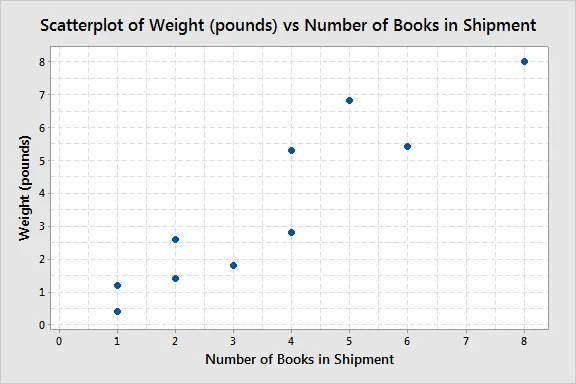

In [ ]:
from PIL import Image
import os

path = "/content/drive/My Drive/Colab Notebooks/COSE474 Deep Learning HW/20242R0136COSE47402/Final Project"

# get images from /data/images directory
filenames =[]
images = []
for filename in os.listdir((path+'/data/images')):
  filenames.append(filename)
  images.append(Image.open(path+'/data/images/'+filename))
print(filenames)
images[2]

In [ ]:
inputs = processor(images=images[2], text="Generate underlying data table of the figure below:", return_tensors="pt").to(device)
predictions = base_model.generate(**inputs, max_new_tokens=512)
table = processor.decode(predictions[0], skip_special_tokens=True)
print(table.replace('<0x0A>','\n'))
print(predictions)

TITLE | Scatterplot of Weight (pounds) vs Number of Books in Shipment
Number of Books in Shipment | Weight (pounds)
0 | 0
1 | 1.20
2 | 2.60
3 | 1.80
4 | 5.30
5 | 6.84
6 | 5.45
7 | 7.90
8 | 8.00
tensor([[    0, 36757,   789,   562,  7926,  4891, 18973,   280, 13687,   304,
         23965,   287,   308,  1797,  4445,   280,  5456,   286, 15820,  3659,
            27,  8047,   280,  5456,   286, 15820,  3659,   789, 13687,   304,
         23965,   287,   308,    27,   278,   789,   273,   278,    27,   277,
           789,   273,   277,   274,   279,   278,    27,   279,   789,   273,
           279,   274,   293,   278,    27,   285,   789,   273,   277,   274,
           294,   278,    27,   289,   789,   273,   290,   274,   285,   278,
            27,   290,   789,   273,   293,   274,   294,   289,    27,   293,
           789,   273,   290,   274,   289,   290,    27,   295,   789,   273,
           295,   274,   292,   278,    27,   294,   789,   273,   294,   274,
           278, 

In [ ]:
inputs = processor(images=images[2], text="Generate underlying data table of the figure below:", return_tensors="pt").to(device)
tuned_predictions = finetuned_model.generate(**inputs, max_new_tokens=512)
tuned_table = processor.decode(tuned_predictions[0], skip_special_tokens=True)
print(tuned_table.replace('<0x0A>','\n'))
print(predictions)

TITLE | Scatterplot of Weight (pounds) vs Number of Books in Shipment 
 Number of Books in Shipment | Weight (pounds) 
 3 | 1.8 
 1 | 1.2 
 2 | 2.6 
 1 | 0.4 
 4 | 5.3 
 6 | 5.4 
 5 | 6.8 
 2 | 1.4 
 1 | 0.4 
 8 | 8 
 6 | 7.9 
 2 | 2.6
tensor([[    0, 36757,   789,   562,  7926,  4891, 18973,   280, 13687,   304,
         23965,   287,   308,  1797,  4445,   280,  5456,   286, 15820,  3659,
            27,  8047,   280,  5456,   286, 15820,  3659,   789, 13687,   304,
         23965,   287,   308,    27,   278,   789,   273,   278,    27,   277,
           789,   273,   277,   274,   279,   278,    27,   279,   789,   273,
           279,   274,   293,   278,    27,   285,   789,   273,   277,   274,
           294,   278,    27,   289,   789,   273,   290,   274,   285,   278,
            27,   290,   789,   273,   293,   274,   294,   289,    27,   293,
           789,   273,   290,   274,   289,   290,    27,   295,   789,   273,
           295,   274,   292,   278,    27,   294,   